# Final project - Advanced Statistical Analysis

**Project Completed by Prashant Khorana, Leonce Ogoussan, and Darshan Padmanabhan**




# Executive Summary

In this project, we examined the motivations of a property owners' tax assessment appeal and what influences the monetary reduction they gain from an appeal.  Reading the literature around the property tax assessment in Chicago County, we found that those initial assessment inaccuracies have led to a multimillion-dollar industry around tax appeals. So, in the first part, we want to understand the factors that lead a property owner to appeal, and in the second part, what factors affect the monetary rewards of appealing.  Using a data set of appeal applications submitted after the first assessment in Chicago, we estimated the probability of successful appeal for property owners using a logistic regression model.  Through rigorous study of the data, we were able to isolate the key factors that play a role in whether a person appeals or not. These factors include the value of the property, property characteristics, and race. We successfully created a model that utilized these characteristics to model appeals with about 75% accuracy.


Then, focusing on property owners who appealed and got some monetary reduction, we created a linear regression model to understand the monetary reduction drivers.  We tested several different models and discovered that the major factors affecting monetary reduction were the ratio of assessed value to actual property value and taxes. We were able to create a highly predictive and simple OLS model using these factors.






In [364]:
# Importing required libraries as needed
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
%matplotlib inline
sns.set(style="ticks", palette="ocean")
sns.despine(ax=None, top=True, right=True, left=False, bottom=False, offset=None, trim=False)

import warnings
warnings.filterwarnings("ignore")

import matplotlib

matplotlib.rcParams['figure.figsize'] = (10,6)
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from sklearn.preprocessing import StandardScaler
from scipy.stats import kurtosis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from scipy.stats import iqr


<Figure size 432x288 with 0 Axes>

Reading in Data and doing some basic explorations

# Dataset Description

In [365]:
df=pd.read_csv("https://raw.githubusercontent.com/openstrategist/Advanced-Statistical-Analysis-uChicago/main/project2.csv")

In [366]:
df.head(5)

pin14      tri pdir  ... high_school_score avg_school_score   appeal
0  2.033200e+13  Chicago    S  ...                 6                4      0.0
1  2.414410e+13  Chicago    S  ...                 8                9      0.0
2  1.408420e+13  Chicago    W  ...                 2                4   4199.0
3  1.419130e+13  Chicago    N  ...                10                9  39109.0
4  1.129100e+13  Chicago    W  ...                 1                2      0.0

[5 rows x 26 columns]

In [367]:
# Data types and missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19036 entries, 0 to 19035
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pin14              19036 non-null  float64
 1   tri                19036 non-null  object 
 2   pdir               13509 non-null  object 
 3   pstreet            19035 non-null  object 
 4   pcity              19035 non-null  object 
 5   tcity              19036 non-null  object 
 6   condo              19036 non-null  object 
 7   av1                18991 non-null  float64
 8   value              19036 non-null  int64  
 9   taxes              19036 non-null  float64
 10  homeowner          19036 non-null  int64  
 11  white              18914 non-null  float64
 12  black              18914 non-null  float64
 13  hispanic           18914 non-null  float64
 14  asian              18914 non-null  float64
 15  medhinc            18914 non-null  float64
 16  poverty            189

In [368]:
df.shape

(19036, 26)

Note that there's 19,036 rows in the raw file and 26 columns.  We think this is a reasonable dataset size for creating predictive models. This number will be reduced after the cleaning process, but as a starting point, we have enough. We can also see that not all the features are numeric and some of them have missing values like "av1", "squarefoot", "beds", etc.

So, let's start cleaning the dataset !

# Dataset Cleaning

The objective of this section will be to address data quality issues. We will find and removes missing values, identify and change data types if necessary, recode variables or add new variables if needed.

Then, we will explore the data by analyzing the location and dispersion of relevant variables and process it as appropriate. This may mean, for example, removing outliers, creating composite variables, or considering the logs of values.

In [369]:
# Finding duplicate rows
duplicate_rows = df[df.duplicated()]
print('We have', len(duplicate_rows), 'observations in the dataset. Duplicates will be removed in the next step.')

We have 132 observations in the dataset. Duplicates will be removed in the next step.


In [370]:
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
df.shape

(18904, 26)

After removing the duplicates, we have 18,904 rows

**Variable "appeal"**

We can see this variable "appeal" having around 53% of null values.  We don't think these null values should be removed.

The data dictionnary describes  the appeal variable as the dollar amount deducted from assessed value after property owner appealed :
- If "NA", there was no appeal.  
- If "0", somebody appealed but no amount was deducted which means the appeal was unsuccessful.

This means, we have to treat this variable in a different way.  So, before we run our Logit model, we swap the NAs under appeal with 0s. Since a significant amount of rows have zero, we do not use dropna for our work.

In [371]:
# Counting NAs for "appeal"
count_na = len(df[df["appeal"].isna()])
count_total = len(df)
pct_na = count_na/count_total

print("Number of rows with <appeal> = NA is", count_na)
print("Percentage of rows with <appeal> = NA is", round(pct_na*100,2))

Number of rows with <appeal> = NA is 9982
Percentage of rows with <appeal> = NA is 52.8


In [372]:
# Create a list of our conditions
conditions = [(df["appeal"] >= 0),(df["appeal"].isna())]
# Create a list of the values we want to assign for each condition
values = [1, 0]
# Create a new column and use np.select to assign values to it using our lists as arguments
df["appealed"] = np.select(conditions, values)
# Now, replace NA values with O to avoid these rows to be deleted
df["appeal"].fillna(0, inplace = True)

**Variable "pdir"**

pdir is the abbreviation for direction in property street address.  We have seen at the beginning that this variable contains 13,509 non-null rows.  So, how to deal with properties with pdir = NA ? Does the direction for a property street address is really important ?

In [373]:
count_null = len(df[df["pdir"].isna()])
count_total = len(df)
pct_zero = count_null/count_total

print("Number of rows with pdir = NA is", count_null)
print("Percentage of rows with pdir = NA is", round(pct_zero*100,2))

Number of rows with pdir = NA is 5439
Percentage of rows with pdir = NA is 28.77


In [374]:
df['pdir'].fillna('Unknown', inplace = True)
df[['pdir', 'appealed']].groupby(['pdir'], as_index=False).mean().sort_values(by='appealed', ascending=False)

pdir  appealed
0        E  0.570248
1        N  0.535115
4        W  0.489556
3  Unknown  0.432616
2        S  0.398202

After replacing the NAs by Unknown, we can see that, there is no so much diffrence between the 5 different values when we look at the mean. 

Looking at the impact of the pdir on taxes amount, we notice above that 'pdir' doesn't tell us anything. Even an transformation wouldn't help us. We have no evidence whether a home in certain direction is worth more or should/should not pay higher taxes.

As such, we will drop it for further analysis. Furthermore, we plan to derive data on location through the 'pin14' item, so we can use that instead.

So, we're going to drop this variable before removing missing values.

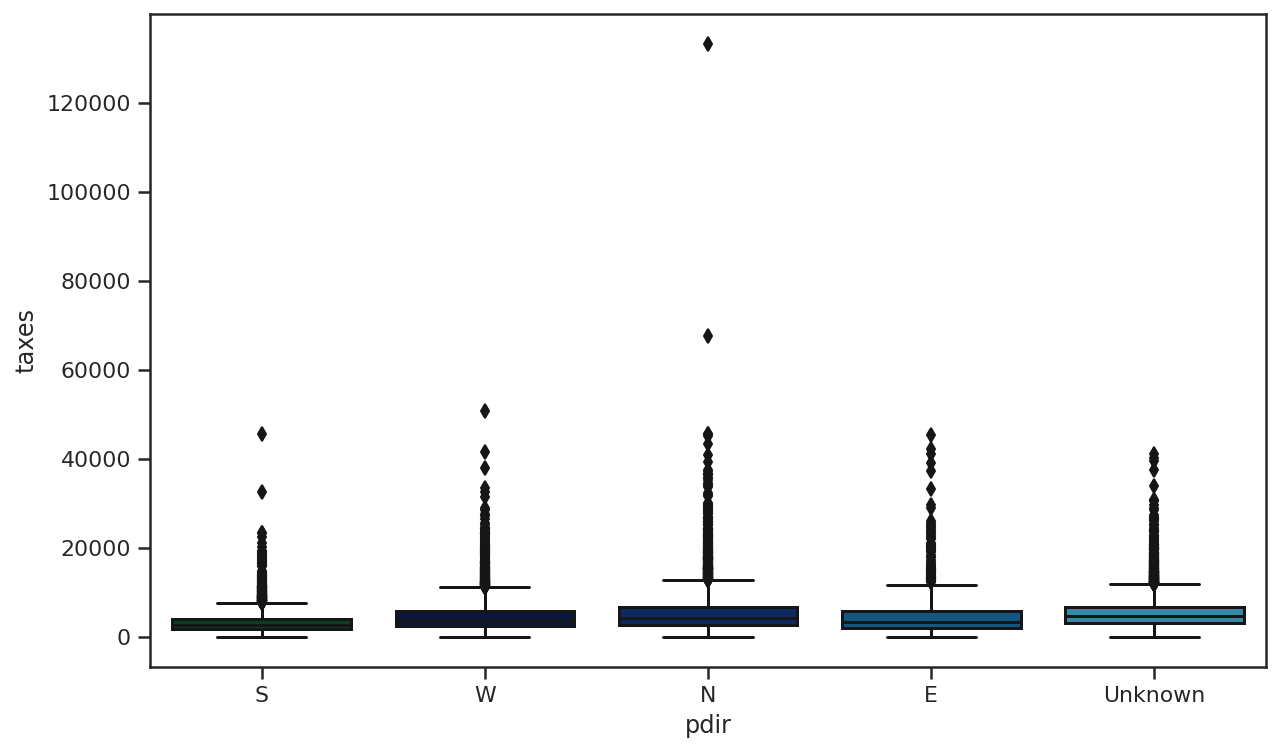

In [375]:
sns.boxplot(data=df,x="pdir",y="taxes")

In [376]:
# Drop the variable "pdir"
df = df.drop(["pdir"], axis=1)

Now that we have applied a specific treatment to the appeal variable, droiped the pdir variable, let's remove missing values.

In [377]:
# Removing missing values
df.dropna(inplace=True)

# No more missing values
df.isna().sum()

pin14                0
tri                  0
pstreet              0
pcity                0
tcity                0
condo                0
av1                  0
value                0
taxes                0
homeowner            0
white                0
black                0
hispanic             0
asian                0
medhinc              0
poverty              0
college              0
squarefoot           0
beds                 0
walkscore            0
walkfac              0
elem_score           0
high_school_score    0
avg_school_score     0
appeal               0
appealed             0
dtype: int64

In [378]:
df.shape

(13747, 26)

**Variable "pin14"**

In [379]:
# All PINs are 14 digits: 2 digits for area + 2 digits for sub area + 3 digits for block + 3 digits for parcel + 4 digits for the multicode
# Let's convert the Pin to str so we can split and use it as a variable
print('Number of unique values in the "pin14" variable is', len(df["pin14"].unique()))

df["pin14"]=df["pin14"].astype(str)

Number of unique values in the "pin14" variable is 4482


In [380]:
# Extracting new variables from pin14

df["pin_area"] = df["pin14"].str[0:2]
df["pin_sub_area"] = df["pin14"].str[2:4]
df["pin_block"] = df["pin14"].str[4:7]
df["pin_parcel"] = df["pin14"].str[7:10]
df["pin_multicode"] = df["pin14"].str[10:14]

In [381]:
df.head()

pin14      tri  pstreet  ... pin_block pin_parcel pin_multicode
0  20332000000000.0  Chicago  LASALLE  ...       200        000          0000
1  24144100000000.0  Chicago   SAWYER  ...       410        000          0000
2  14084200000000.0  Chicago  AINSLIE  ...       420        000          0000
3  14191300000000.0  Chicago   OAKLEY  ...       130        000          0000
4  11291000000000.0  Chicago  JUNEWAY  ...       100        000          0000

[5 rows x 31 columns]

Variables "pin_parcel" and "pin_multicode" seems to have a unique value and containing only zeros.  Let's check and remove them if it's the case

In [382]:
print("Nb of unique values for pin_parcel:", len(pd.unique(df['pin_parcel'])) )

print("Nb of unique values for pin_multicode:", len(pd.unique(df['pin_multicode'])))

Nb of unique values for pin_parcel: 1
Nb of unique values for pin_multicode: 1


The variable "pin14" is described as the unique "Permanent Identification Number" for each property. So, the number of unique values for the variable pin14 should be equals to the total number of rows. We have 4682 unique values for the "pin14" variable which means that it might be possible the variable has been masked for privacy.  Only the first part area, sub_area and block is kept.

In [383]:
# Drop the variables "pin14", "pin_parcel" and "pin_multicode"
df = df.drop(["pin14", "pin_parcel", "pin_multicode"], axis=1)

**Variable "condo"**

This variable classifies a property as condominium or non-condominium.  After the first main steps of dataset cleaning, it appears that this variable now contains one unique value : "Non-condo".  This variable will be removed from the dataset.

In [384]:
df["condo"].unique()

array(['Non-condo'], dtype=object)

In [385]:
# Drop the variable "condo"
df = df.drop(["condo"], axis=1)

**Dataset statistics**

In [386]:
# Dataset statistics
df.describe()

av1         value  ...         appeal      appealed
count   13747.000000  1.374700e+04  ...   13747.000000  13747.000000
mean    31330.941515  3.574328e+05  ...    2558.763367      0.461264
std     28559.994974  3.463836e+05  ...   10967.734241      0.498515
min   -340719.000000  1.350000e+04  ...       0.000000      0.000000
25%     15362.000000  1.690000e+05  ...       0.000000      0.000000
50%     23748.000000  2.600000e+05  ...       0.000000      0.000000
75%     38272.000000  4.230000e+05  ...     895.500000      1.000000
max    485982.000000  6.334000e+06  ...  419346.000000      1.000000

[8 rows x 19 columns]

**Variable "av1"**

The table above is showing that we have negative values for the assessment which is unusual. Let's try to see how many rows we have and remove them.

In [387]:
count_negative = len(df[df["av1"] < 0])
count_total = len(df)
pct_negative = count_negative/count_total

print("Number of rows with negative av1 is", count_negative)
print("Percentage of rows with negative av1 is", round(pct_negative*100,2))

Number of rows with negative av1 is 164
Percentage of rows with negative av1 is 1.19


In [388]:
# Removing negative values for av1
df = df[(df["av1"] >= 0)]

**Variable "squarefoot"**

The table above is showing that we have properties with squarefoot value equals to zero which is unusual.  Let's try to see how many rows we have and remove them.

In [389]:
count_zeros = len(df[df["squarefoot"] == 0])
count_total = len(df)
pct_zeros = count_zeros/count_total

print("Number of rows with squarefoot equals zero is", count_zeros)
print("Percentage of rows with squarefoot equals zero is", round(pct_zeros*100,2))

Number of rows with squarefoot equals zero is 10
Percentage of rows with squarefoot equals zero is 0.07


In [390]:
# Removing negative values for squarefoot
df = df[(df["squarefoot"] > 0)]

**Variable "taxes"**

The table above is showing that we have zero values for the taxes amount.  We assume that there is no reason to make an appeal if you are not paying taxes or even if you are making an appeal, this decision is not related to the tax amount (noone is amking an appeal to pay taxes).  Therefore, we need to exclude property owner which taxes amount are equal to zero.

In [391]:
count_zeros = len(df[df["taxes"] == 0])
count_total = len(df)
pct_zeros = count_zeros/count_total

print("Number of rows with taxes equals zero is", count_zeros)
print("Percentage of rows with taxes equals zero is", round(pct_zeros*100,2))

Number of rows with taxes equals zero is 46
Percentage of rows with taxes equals zero is 0.34


In [392]:
# Removing negative values for taxes
df = df[(df["taxes"] > 0)]

In [393]:
# Dataset statistics
df.describe()

av1         value  ...         appeal      appealed
count   13527.000000  1.352700e+04  ...   13527.000000  13527.000000
mean    31974.478820  3.590607e+05  ...    2111.304724      0.454572
std     27804.526578  3.465115e+05  ...    8601.722826      0.497950
min       452.000000  1.750000e+04  ...       0.000000      0.000000
25%     15671.500000  1.700000e+05  ...       0.000000      0.000000
50%     23979.000000  2.600000e+05  ...       0.000000      0.000000
75%     38538.500000  4.250000e+05  ...     660.500000      1.000000
max    485982.000000  6.334000e+06  ...  320827.000000      1.000000

[8 rows x 19 columns]

Running again statistics on the dataset show that we have also clean the "beds" variables which was also containing zero values.

**Now, let us investigate the values and look for outliers**

**Skewness for 'av1'**

skewness = 3.7622134406855645


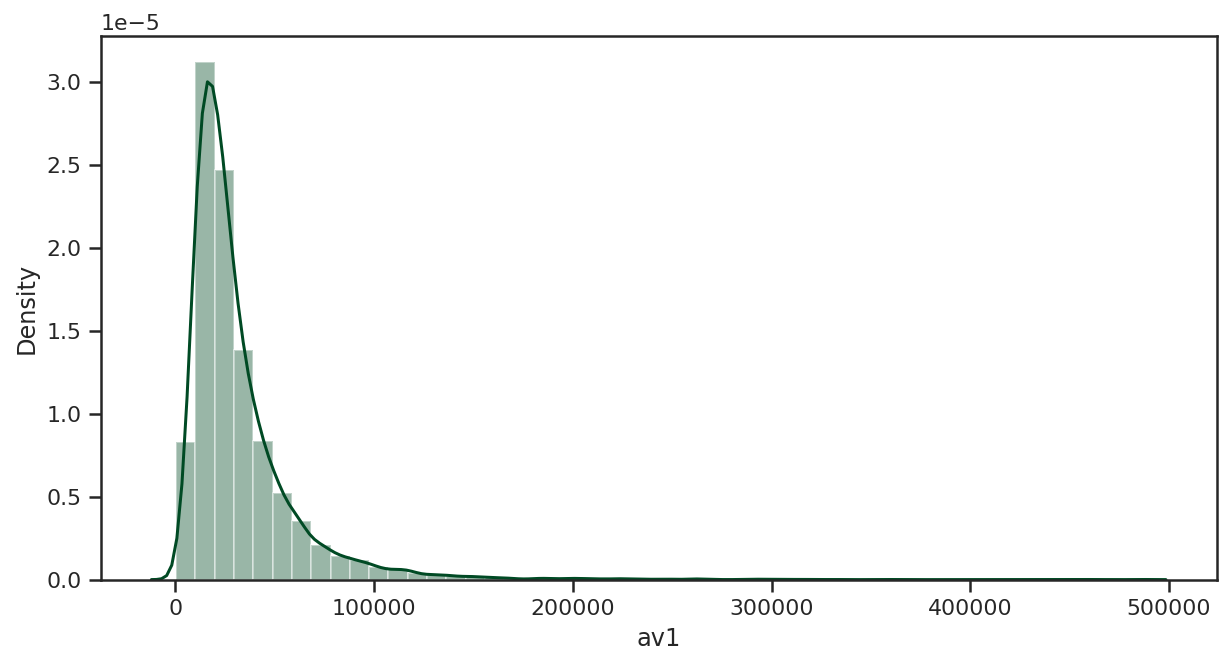

In [394]:
# Finding skewness
print('skewness =', df['av1'].skew())

# Visualizing the variable (av1)
f, axes = plt.subplots(figsize=(10,5))
sns.distplot(df['av1'])

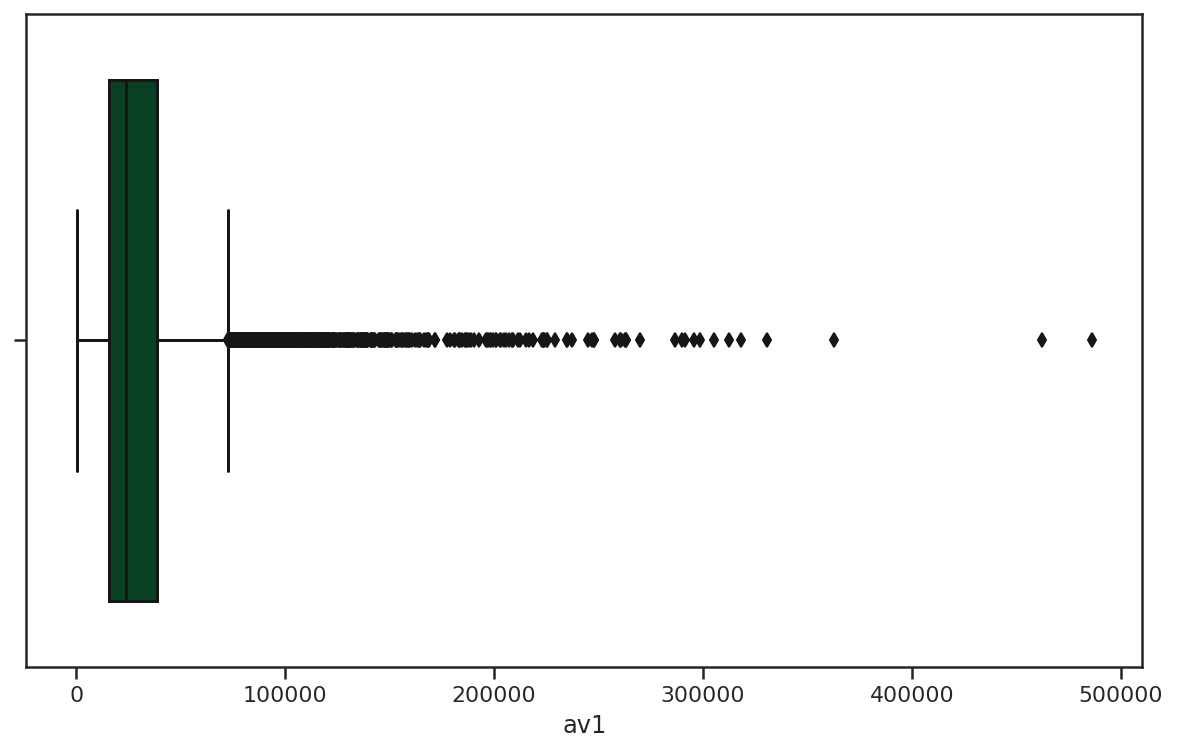

In [395]:
# Box plot
sns.boxplot(df['av1'])

**Skewness for 'medhinc'**

skewness = 1.094411631997208


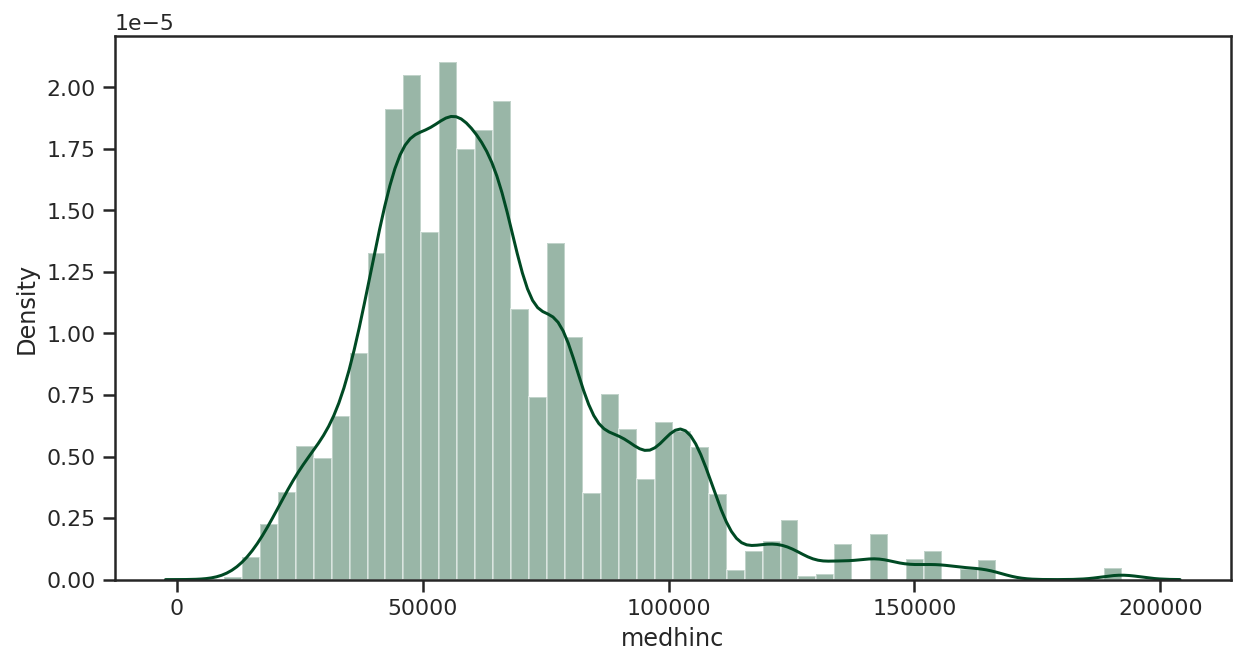

In [396]:
# Finding skewness
print('skewness =', df['medhinc'].skew())

# Visualizing the variable (av1)
f, axes = plt.subplots(figsize=(10,5))
sns.distplot(df['medhinc'])

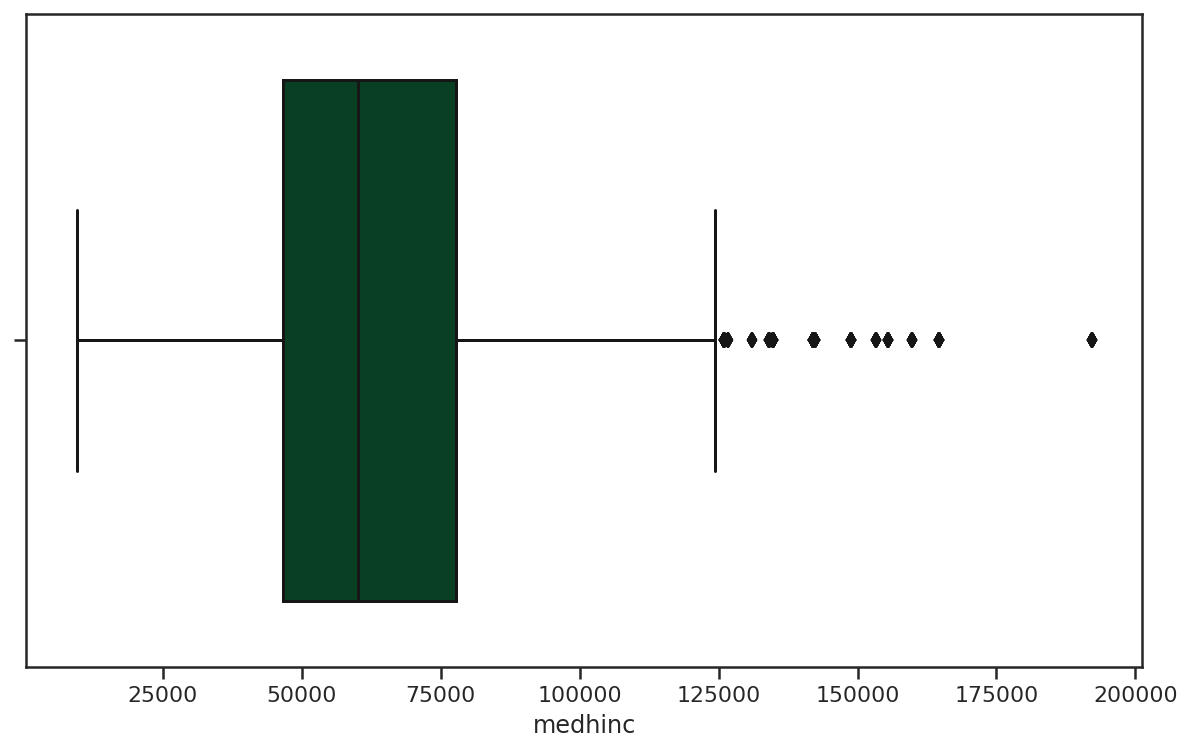

In [397]:
# Box plot
sns.boxplot(df['medhinc'])

**Skewness for 'taxes'**

skewness = 2.675840864135953


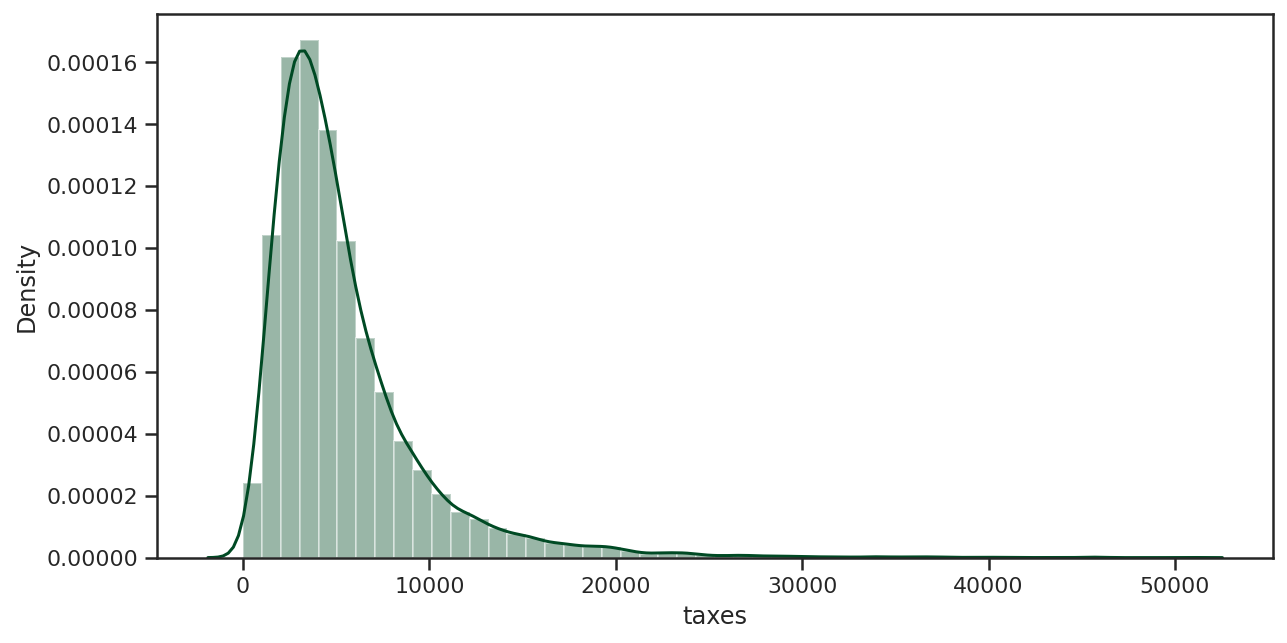

In [398]:
# Finding skewness
print('skewness =', df['taxes'].skew())

# Visualizing the variable (appeal)
f, axes = plt.subplots(figsize=(10,5))
sns.distplot(df['taxes'])

**Skewness for 'value'**

skewness = 4.743885813014708


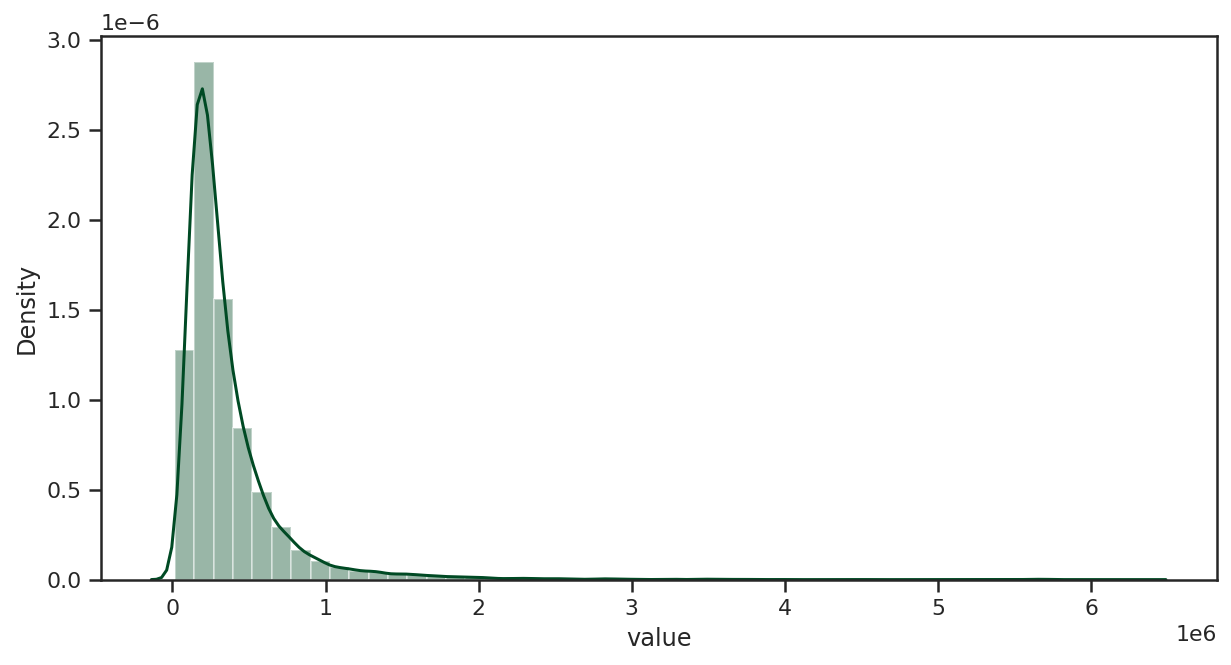

In [399]:
# Finding skewness
print('skewness =', df['value'].skew())

# Visualizing the variable (appeal)
f, axes = plt.subplots(figsize=(10,5))
sns.distplot(df['value'])

**Skewness for 'squarefoot'**

skewness = 3.188465176882944


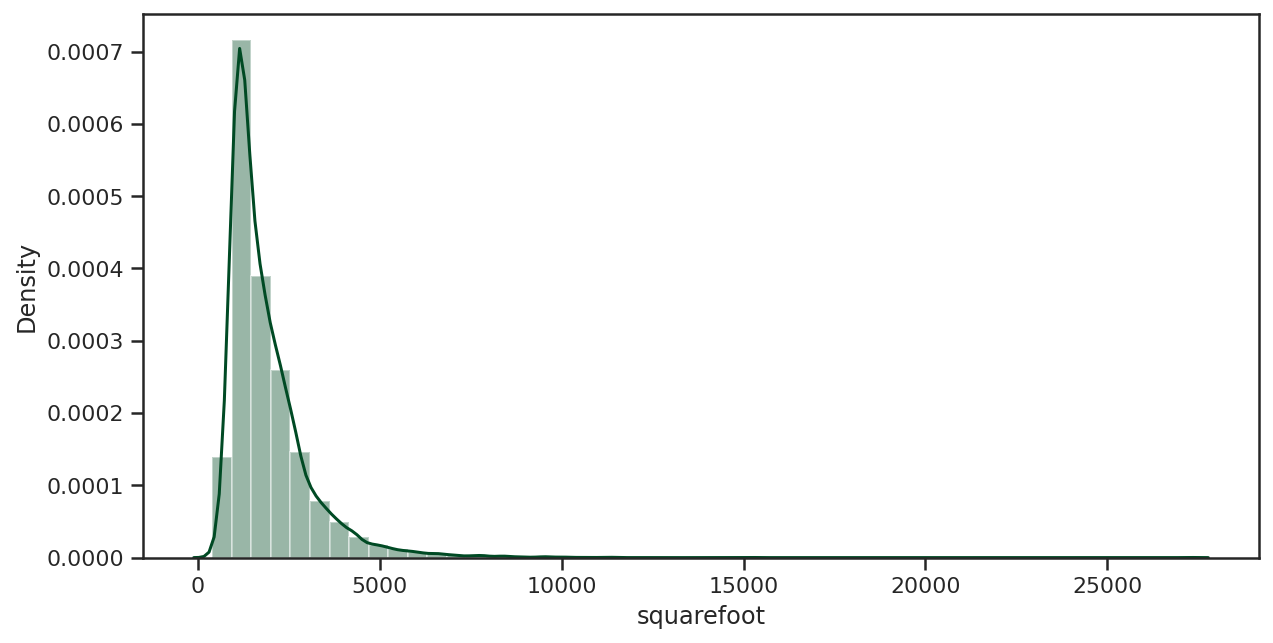

In [400]:
# Finding skewness
print('skewness =', df['squarefoot'].skew())

# Visualizing the variable (squarefoot)
f, axes = plt.subplots(figsize=(10,5))
sns.distplot(df['squarefoot'])

**Skewness for 'appeal'**

skewness = 12.128199709892945


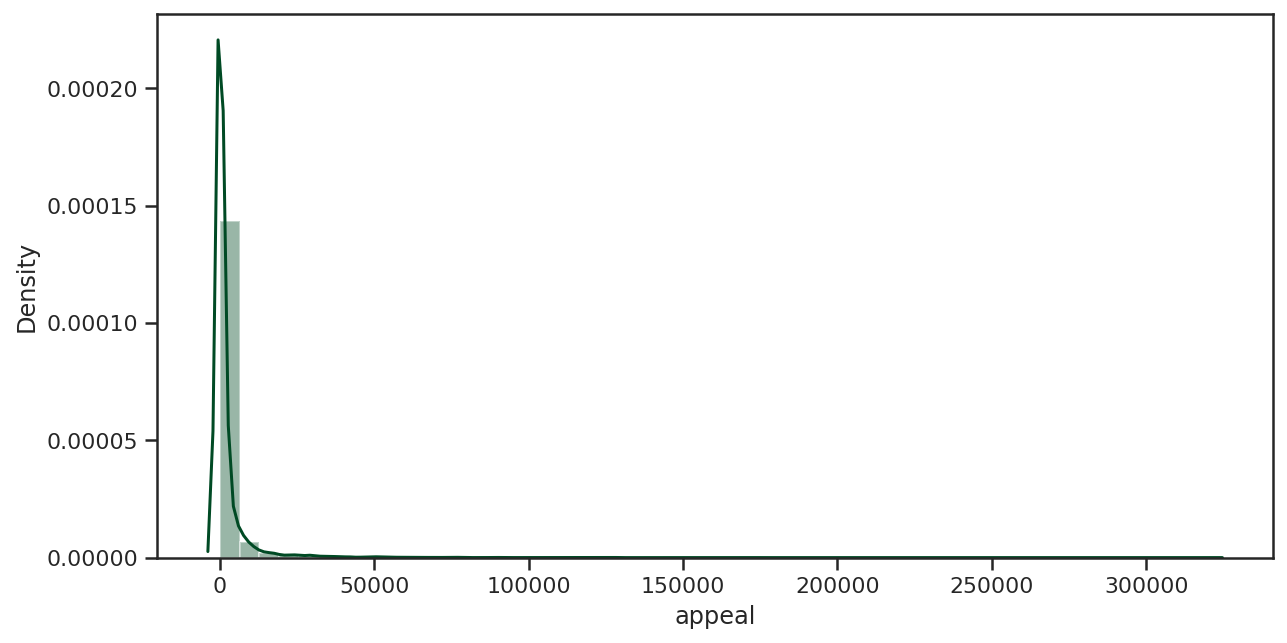

In [401]:
# Finding skewness
print('skewness =', df['appeal'].skew())

# Visualizing the variable (appeal)
f, axes = plt.subplots(figsize=(10,5))
sns.distplot(df['appeal'])

Conclusions on variables skewness

- Variables 'av1', 'taxes', 'medhinc', 'value', and 'squarefoot' all exhibit skewness and need cleaning for iqr values. 
- We also note that there is a very strong long-tail effect caused by the skewness. As such, removing the tails will help us build a good model.


So let's remove outliers using IQR ranges !

**Cleaning IQR Ranges**

In [402]:
def iqr_cleaning(column_names):

  q1s = []
  q3s = []
  iqrs = []
  floors = []
  ceilings = []

  for column in column_names:
    
    q1 = df[column].quantile(0.25)
    q3 = df[column].quantile(0.75)
    iqr = q3 - q1

    q1s.append(q1)
    q3s.append(q3)
    iqrs.append(iqr)

    floor = q1-1.5*iqr
    ceiling = q3+1.5*iqr

    if floor > 0:
      pass
    else:
      floor=0


    floors.append(floor)
    ceilings.append(ceiling)

  df_cleaned_quartile=df.copy()
  
  df_cleaned_quartile = df_cleaned_quartile[df_cleaned_quartile[column_names[0]].between(floors[0], ceilings[0])]
  df_cleaned_quartile = df_cleaned_quartile[df_cleaned_quartile[column_names[1]].between(floors[1], ceilings[1])]
  df_cleaned_quartile = df_cleaned_quartile[df_cleaned_quartile[column_names[2]].between(floors[2], ceilings[2])]
  df_cleaned_quartile = df_cleaned_quartile[df_cleaned_quartile[column_names[2]].between(floors[3], ceilings[3])]
  
  return df_cleaned_quartile

In [403]:
df = iqr_cleaning(['av1','value','squarefoot','medhinc'])

**Taking the log values of several columns to eliminate skew and normalize values**

In [404]:
df['log_taxes'] = np.log(df['taxes'])
df['log_squarefoot'] = np.log(df['squarefoot'])
df['log_medhinc'] = np.log(df['medhinc'])
df['log_value'] = np.log(df['value'])
df["log_beds"] = np.log(df['beds'])
df['log_av1'] = np.log(df['av1'])

In [405]:
df.columns

Index(['tri', 'pstreet', 'pcity', 'tcity', 'av1', 'value', 'taxes',
       'homeowner', 'white', 'black', 'hispanic', 'asian', 'medhinc',
       'poverty', 'college', 'squarefoot', 'beds', 'walkscore', 'walkfac',
       'elem_score', 'high_school_score', 'avg_school_score', 'appeal',
       'appealed', 'pin_area', 'pin_sub_area', 'pin_block', 'log_taxes',
       'log_squarefoot', 'log_medhinc', 'log_value', 'log_beds', 'log_av1'],
      dtype='object')

**Changing data types from str to float**

In [406]:
df["pin_area"] = df["pin_area"].astype(float)
df["pin_sub_area"] = df["pin_sub_area"].astype(float)
df["pin_block"] = df["pin_block"].astype(float)

In [407]:
df.shape

(11969, 33)

Before starting exploring the data visually, we have 11,969 rows in our dataset.

In [408]:
df[['homeowner', 'appealed']].groupby(['homeowner'], as_index=False).mean().sort_values(by='appealed', ascending=False)

homeowner  appealed
1          1  0.464490
0          0  0.379104

In [409]:
df[['elem_score', 'appealed']].groupby(['elem_score'], as_index=False).mean().sort_values(by='appealed', ascending=False)

elem_score  appealed
9          10  0.563265
8           9  0.550400
7           8  0.512491
6           7  0.480595
5           6  0.441246
4           5  0.410683
3           4  0.394083
2           3  0.365623
1           2  0.339623
0           1  0.301242

# Exploratory Data Analysis

Let us generate a quick heatmap to understand which variables hold explanatory power. 


Let us generate a correlation matrix and take a look at key variables.

In [410]:
keep_cols = df.columns[df.nunique() > 1]
numerical_cols = df[keep_cols].select_dtypes('number').columns
correlation = df.corr()

In [411]:
mask = np.triu(np.ones_like(correlation, dtype=bool))

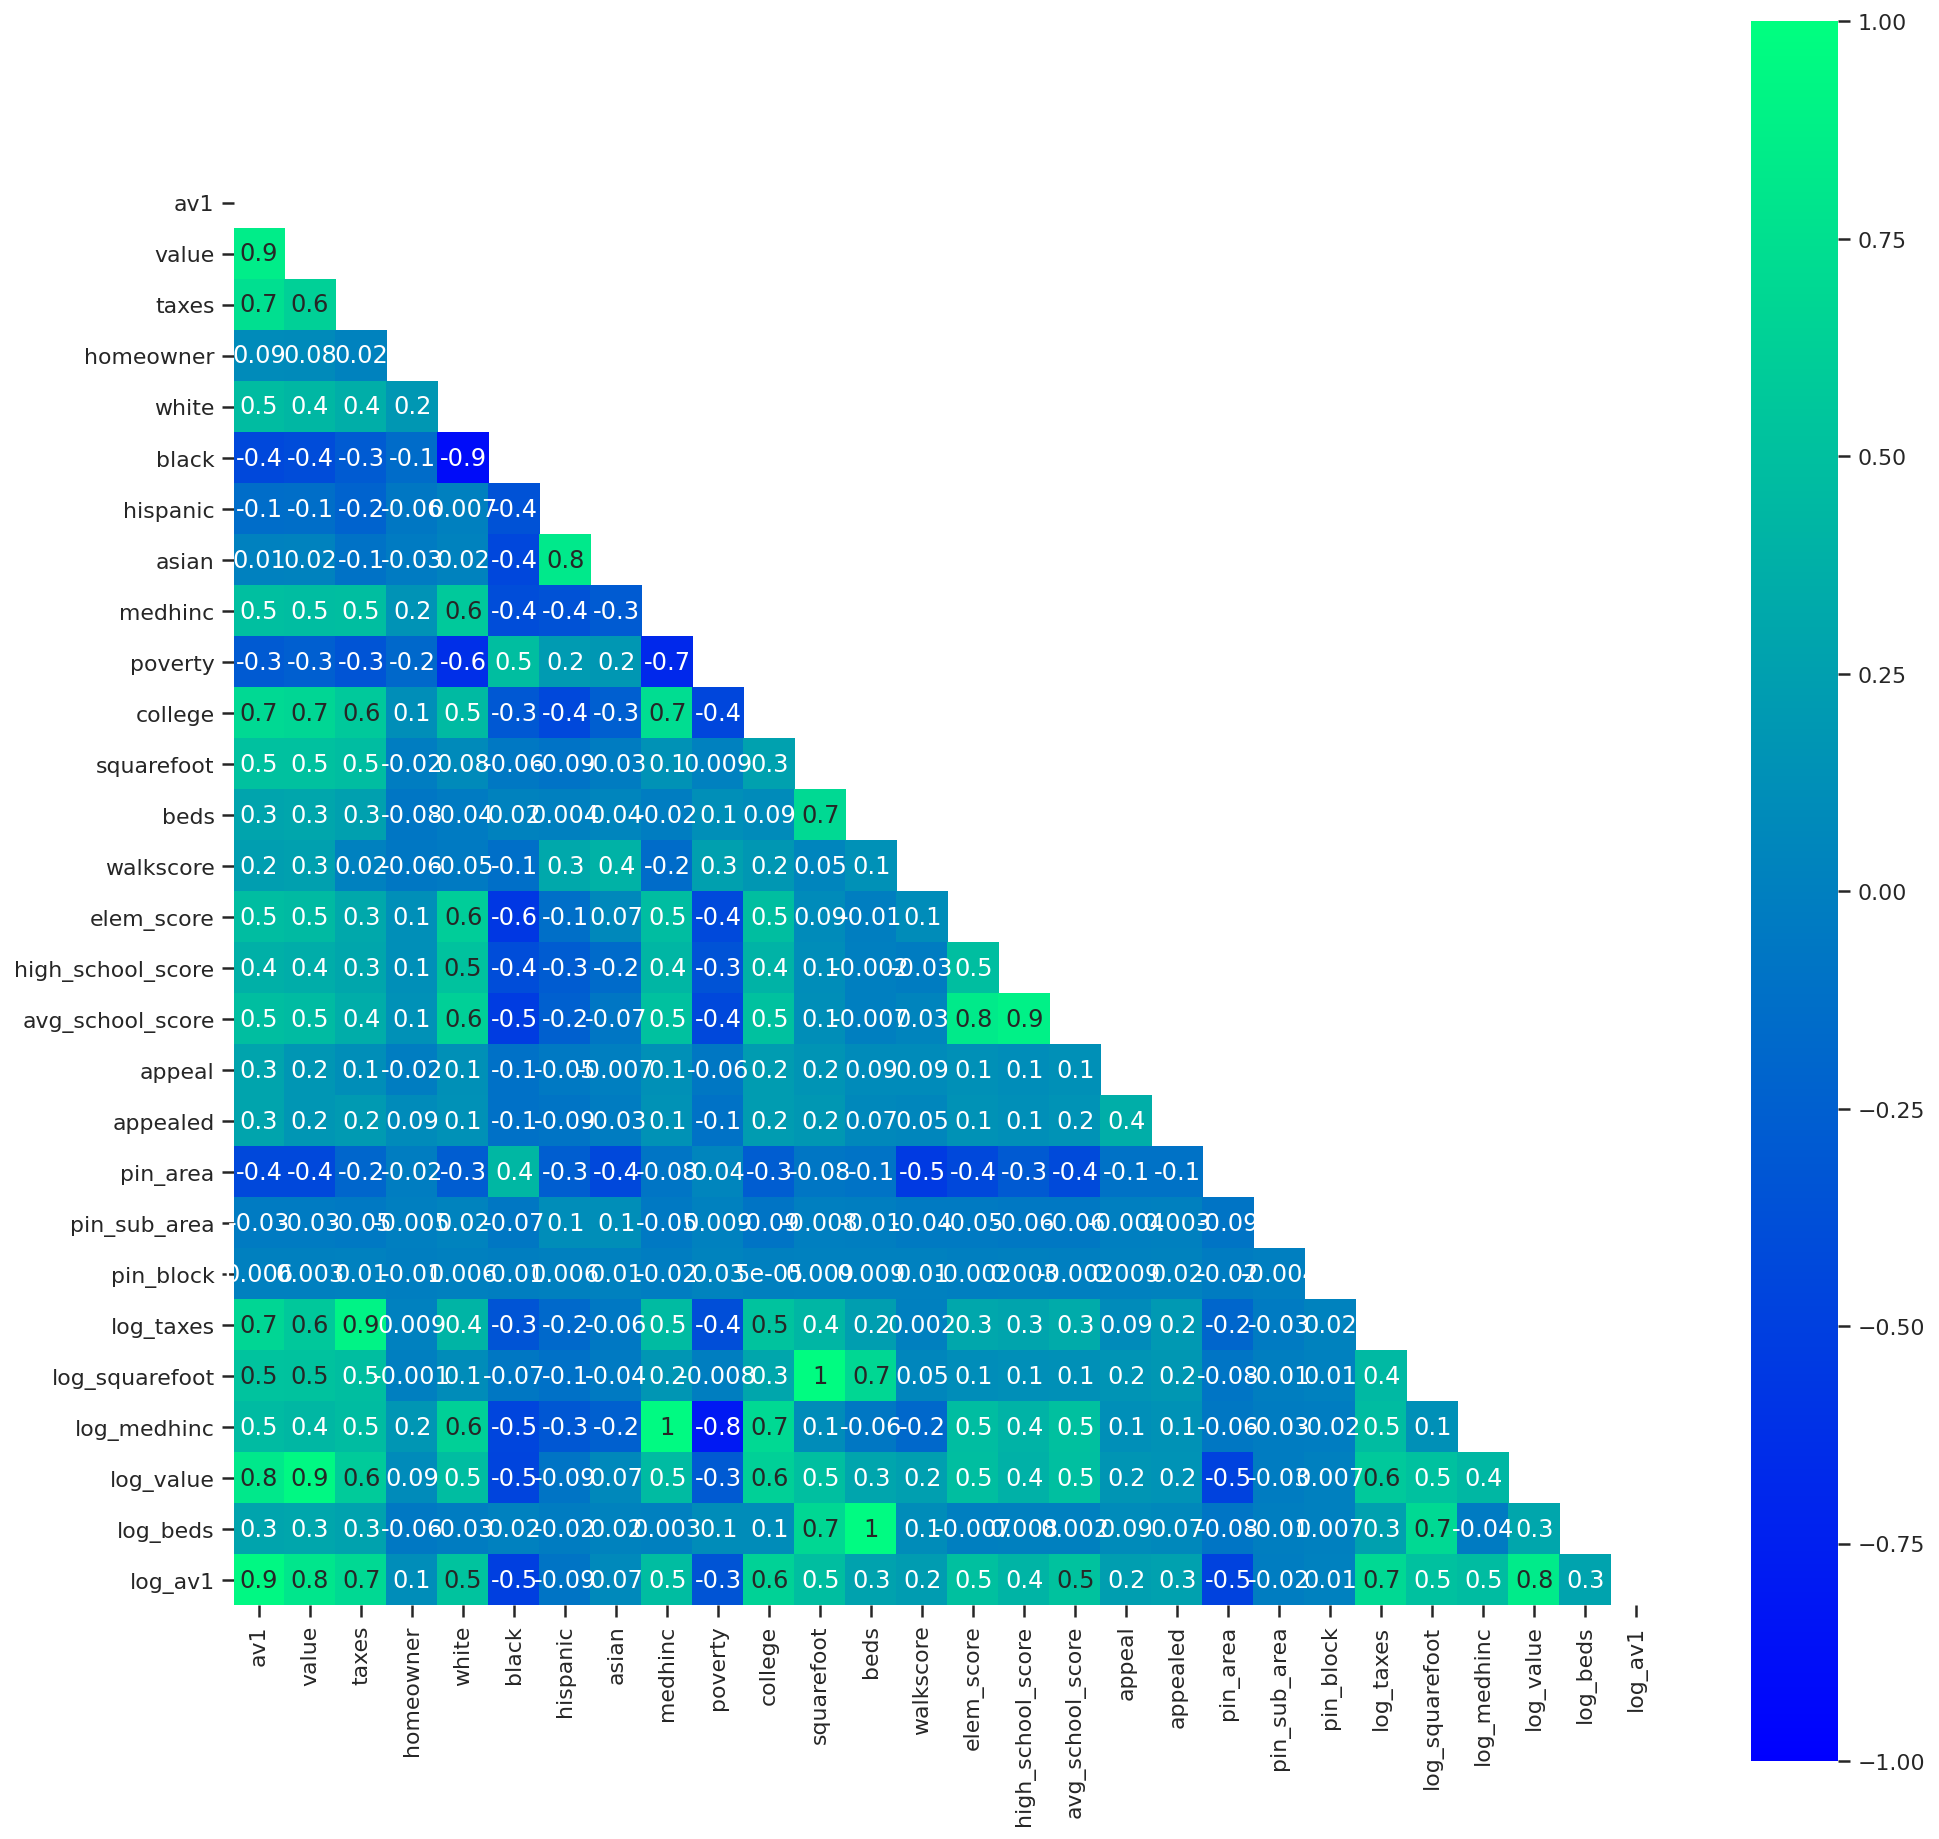

In [412]:
f, ax = plt.subplots(figsize=(16, 16))
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
#cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(correlation, annot = True, fmt='.1g', center= 0, square=True, mask=mask, cmap  = 'winter', vmax = 1, vmin = -1)

From the correlation matrix above, we observe that factors such as taxes, race (mostly whether someone is black or white), college eduction, square footage of the rooms, and median income are important.


**Variable "beds"**

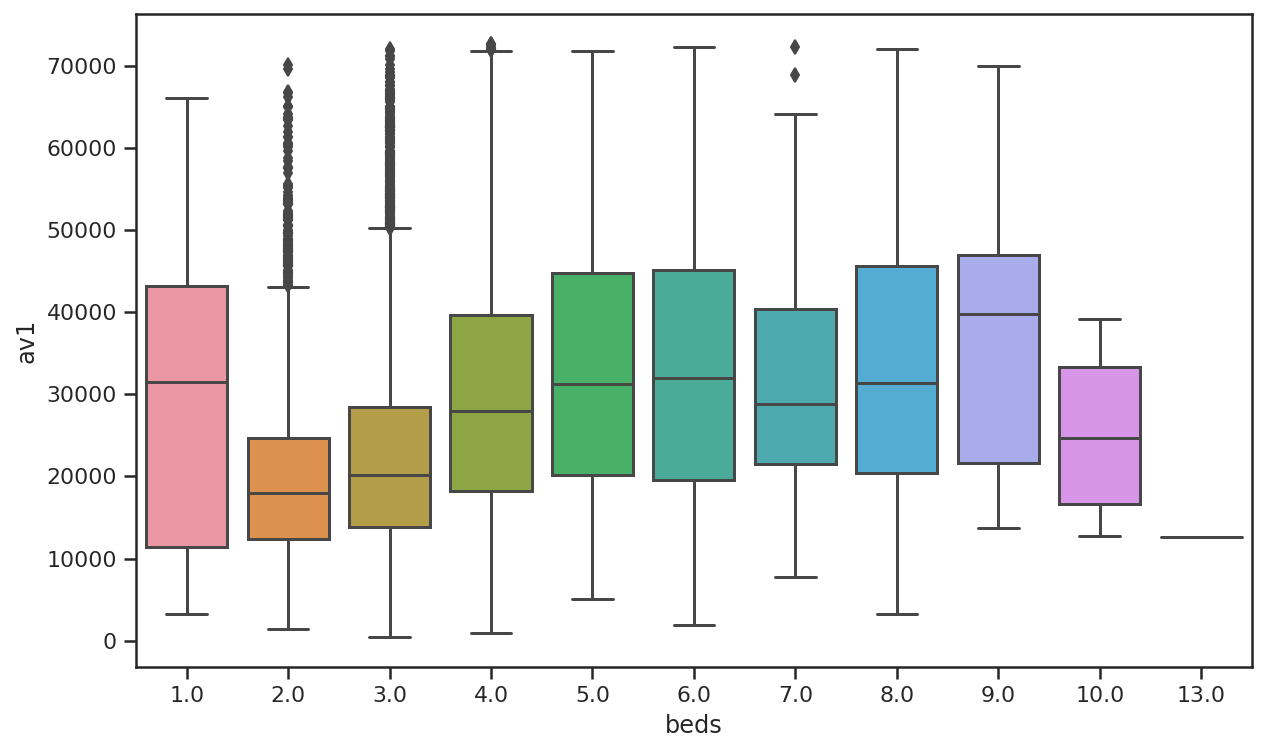

In [413]:
sns.boxplot(data=df,x="beds",y="av1")

- We notice above that increasing number of beds doesn't imply a strict increase in home value. 
- A large number of homes have between three and six beds, which reconciles with general homeownership patterns.

**Variable 'av1' versus race variables 'white', 'black', 'hispanic', 'asian'**

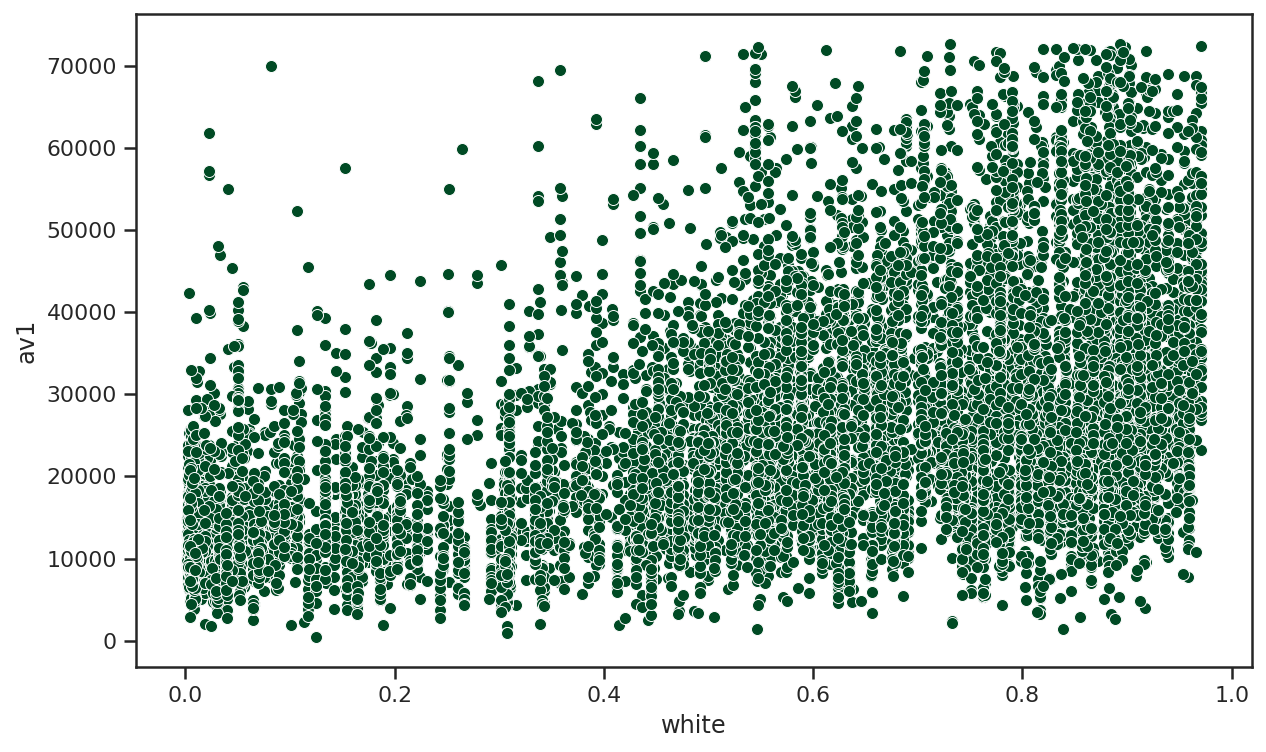

In [414]:
sns.scatterplot(data=df,x="white",y="av1")

Note that higher levels of 'white' penetration is positively correlated with assessed value...




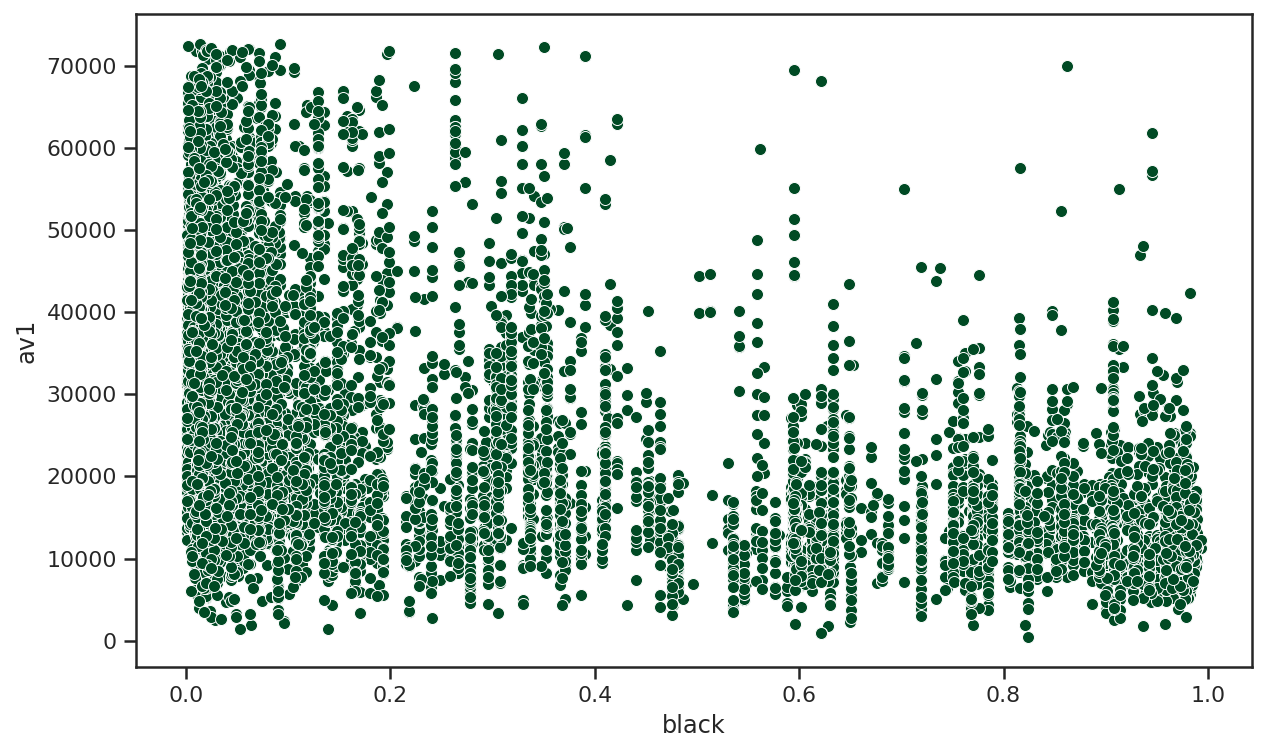

In [415]:
sns.scatterplot(data=df,x="black",y="av1")

...and that higher levels of 'black' penetration is negatively correlated with assessed value



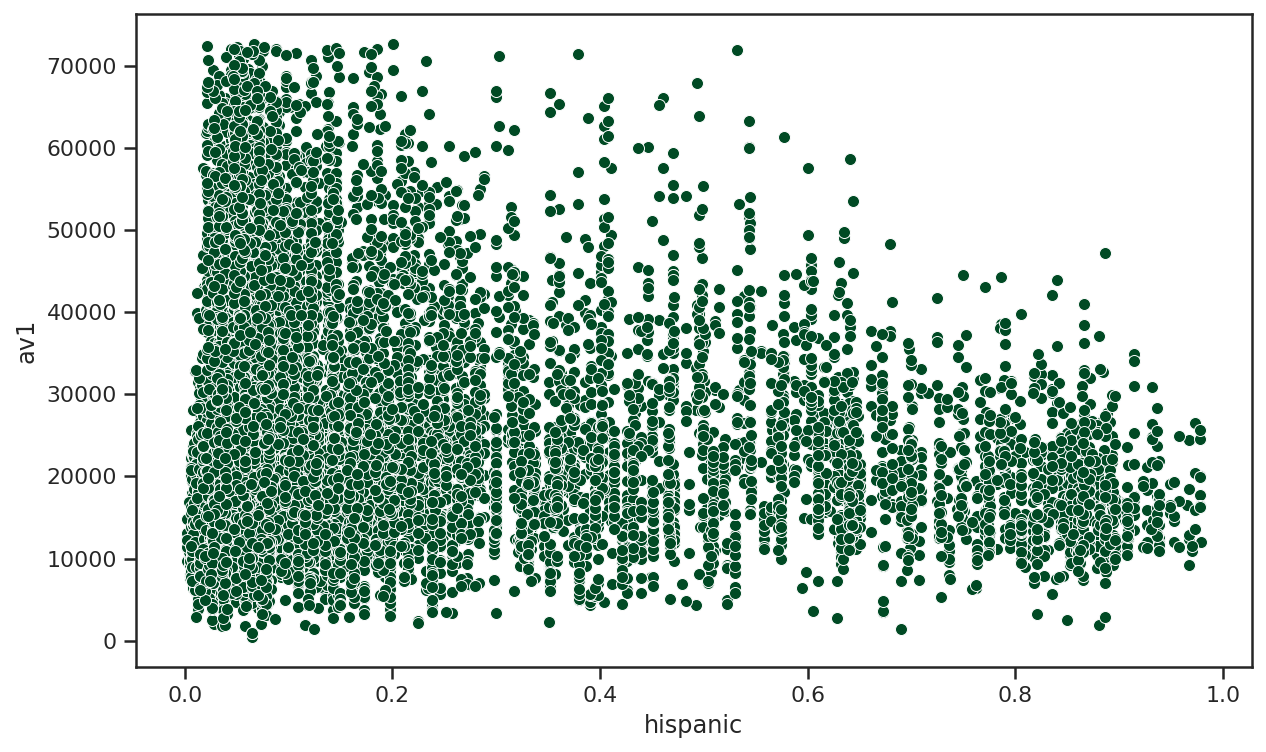

In [416]:
sns.scatterplot(data=df,x="hispanic",y="av1")

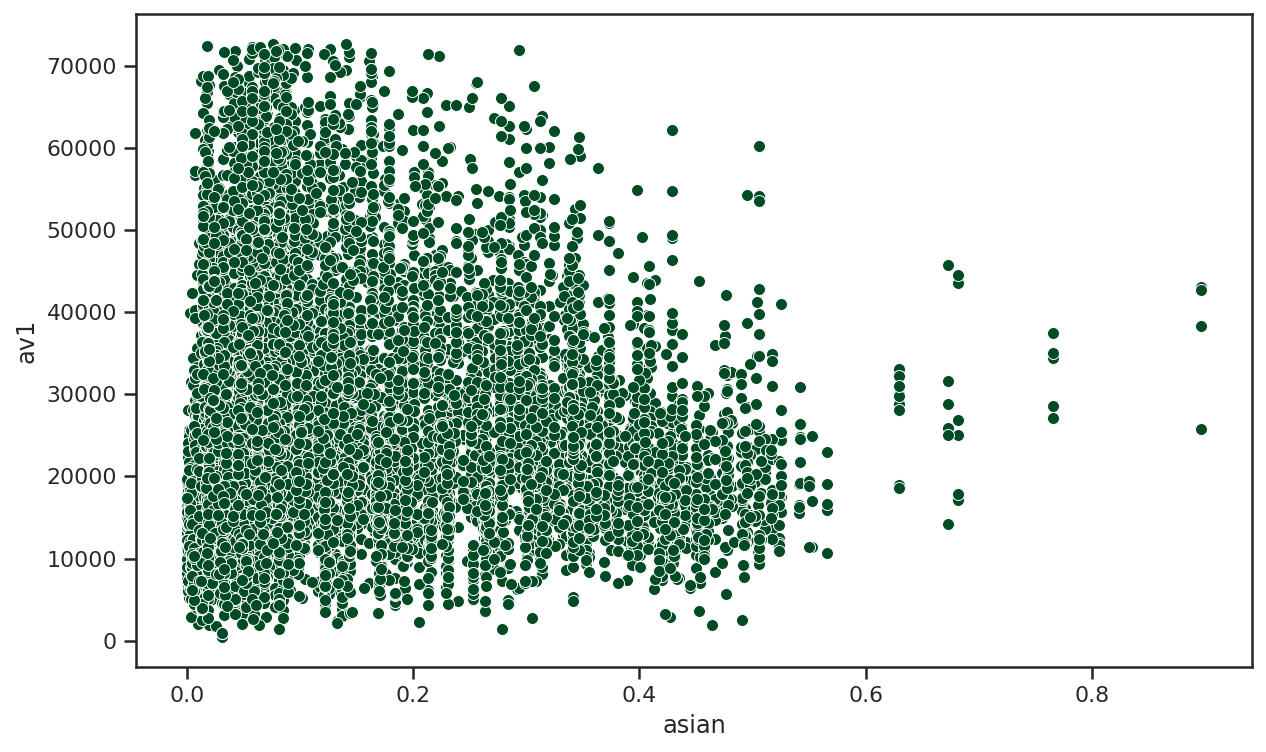

In [417]:
sns.scatterplot(data=df,x="asian",y="av1")

Asian and hispanic variables are not as strongly correlated to assessed value as other variables mentioned above

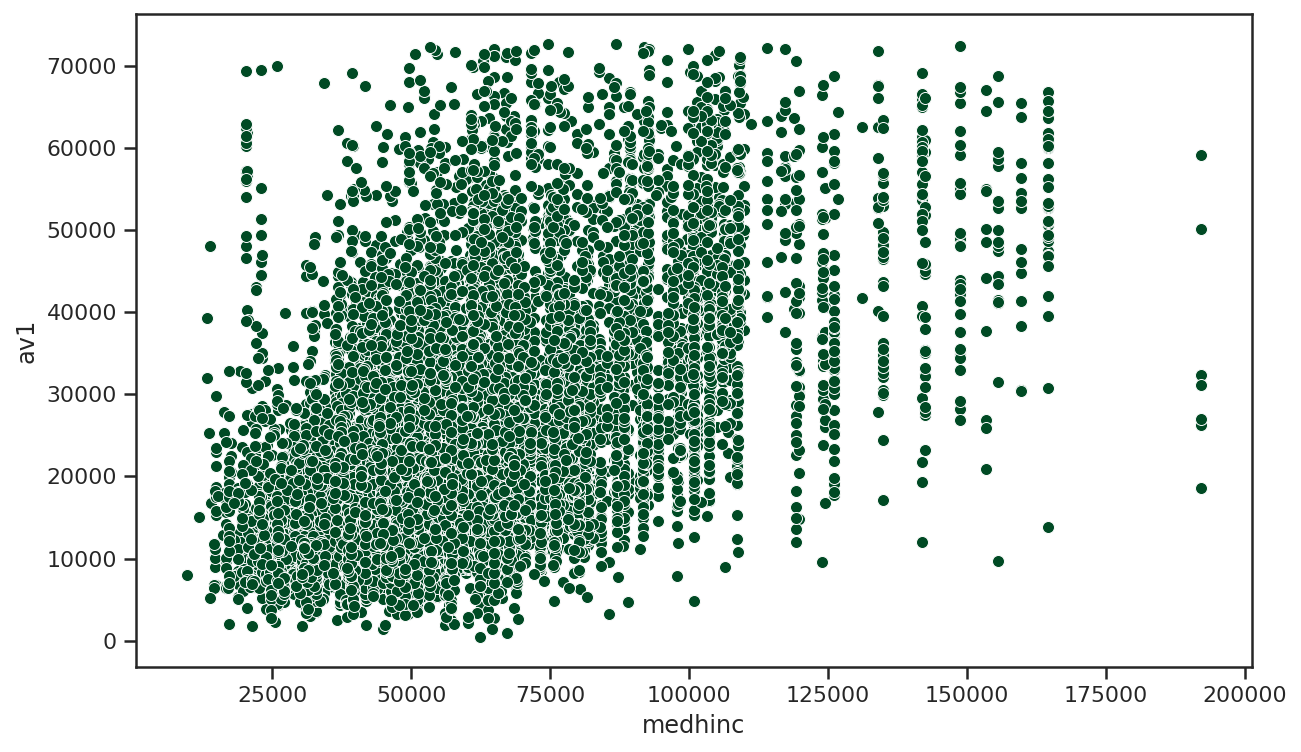

In [418]:
sns.scatterplot(data=df,x="medhinc",y="av1")

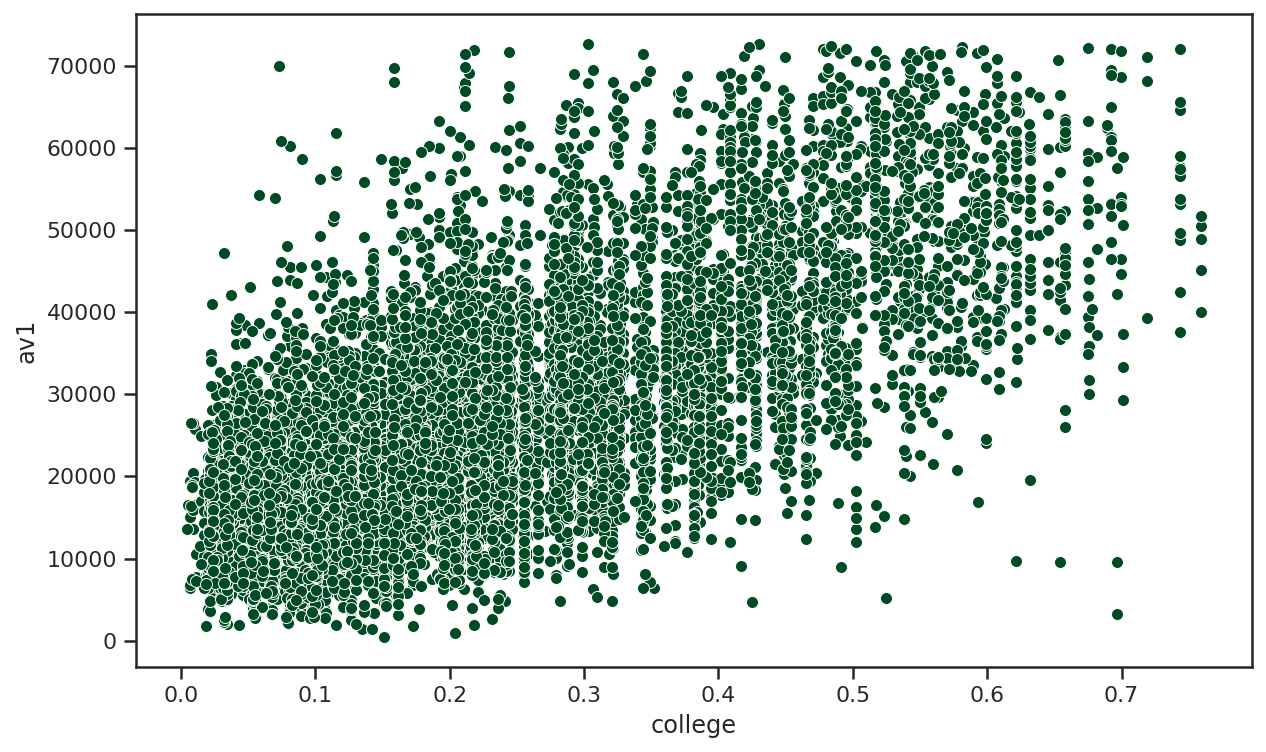

In [419]:
sns.scatterplot(data=df,x="college",y="av1")

### Higher levels of college eduction and median income are positively correlated to higher assessed values

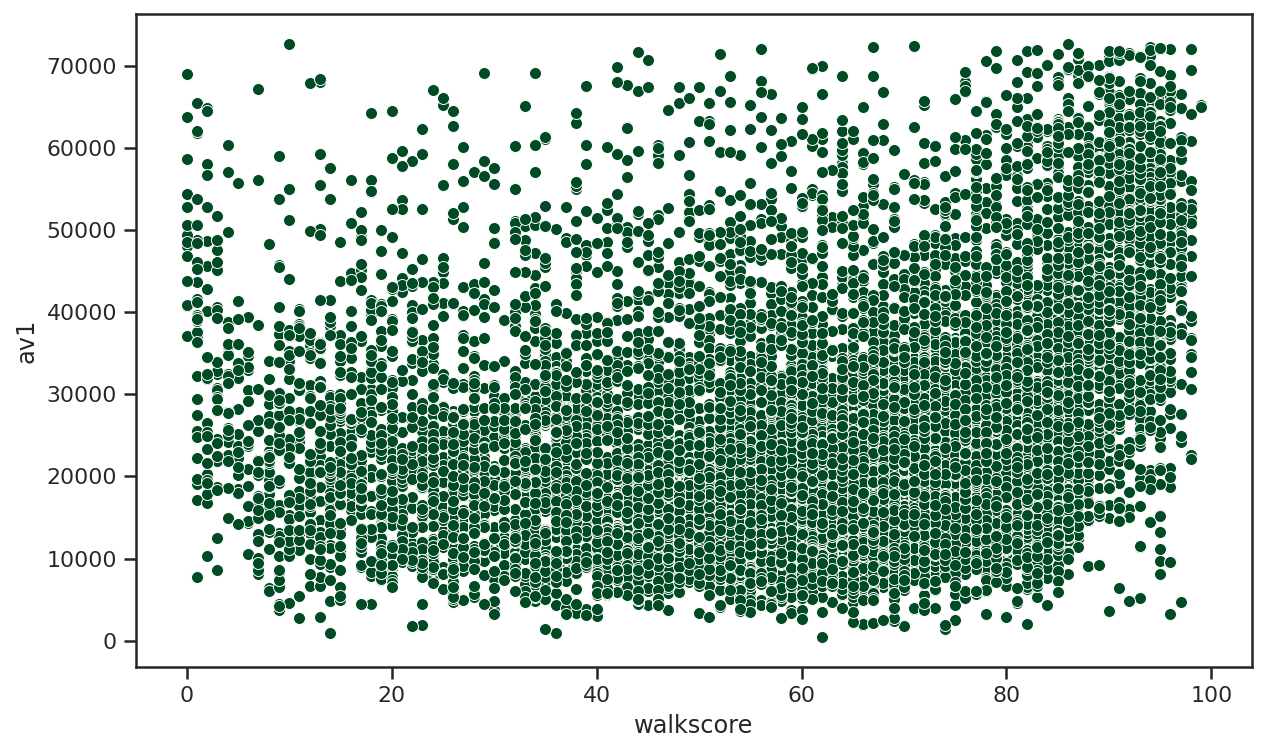

In [420]:
sns.scatterplot(data=df,x="walkscore",y="av1")

### Walkscore by itself doesn't seem to be highly predictive. However, we do notice that higher walkscore neighborhoods have higher assessed values.

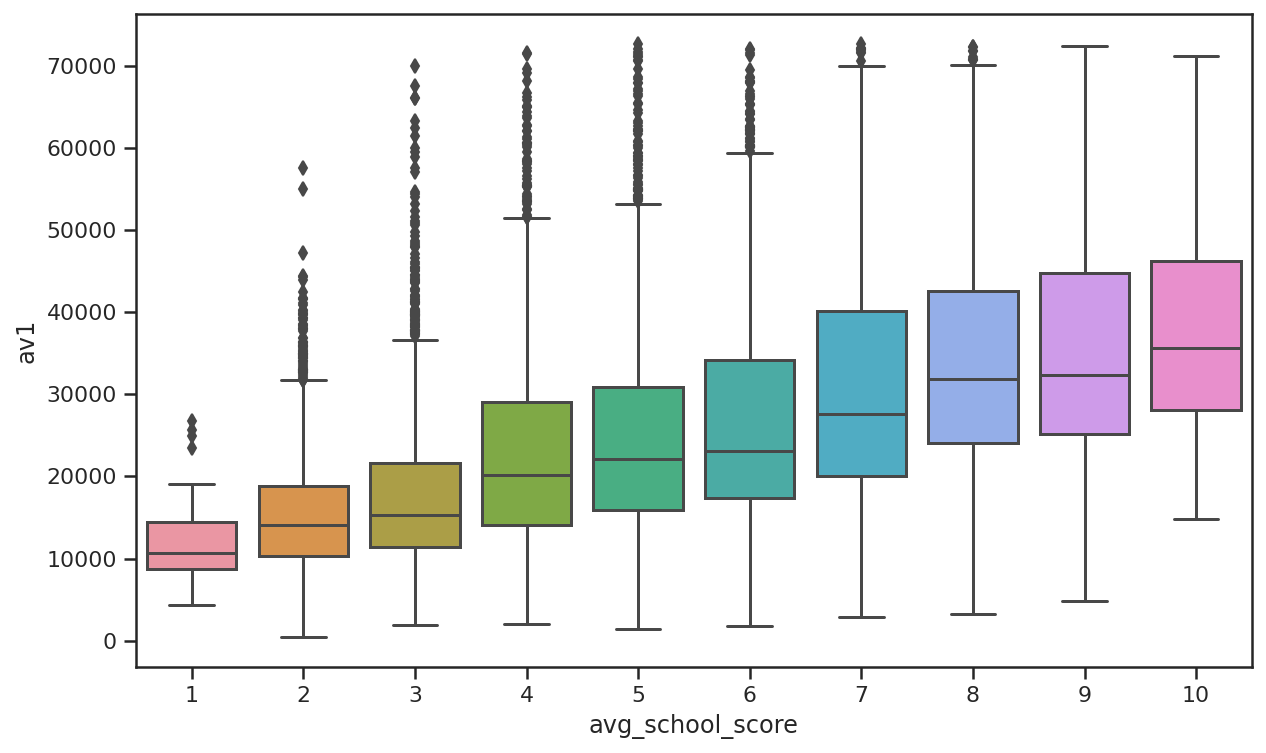

In [421]:
sns.boxplot(data=df,x="avg_school_score",y="av1")

### average school score is positively correlated to av1

# Model Training

Now we build towards developing a logit model for whether or not a property owner will apeal. 

In [422]:
X = df.drop('appealed', axis=1)
y = df['appealed']

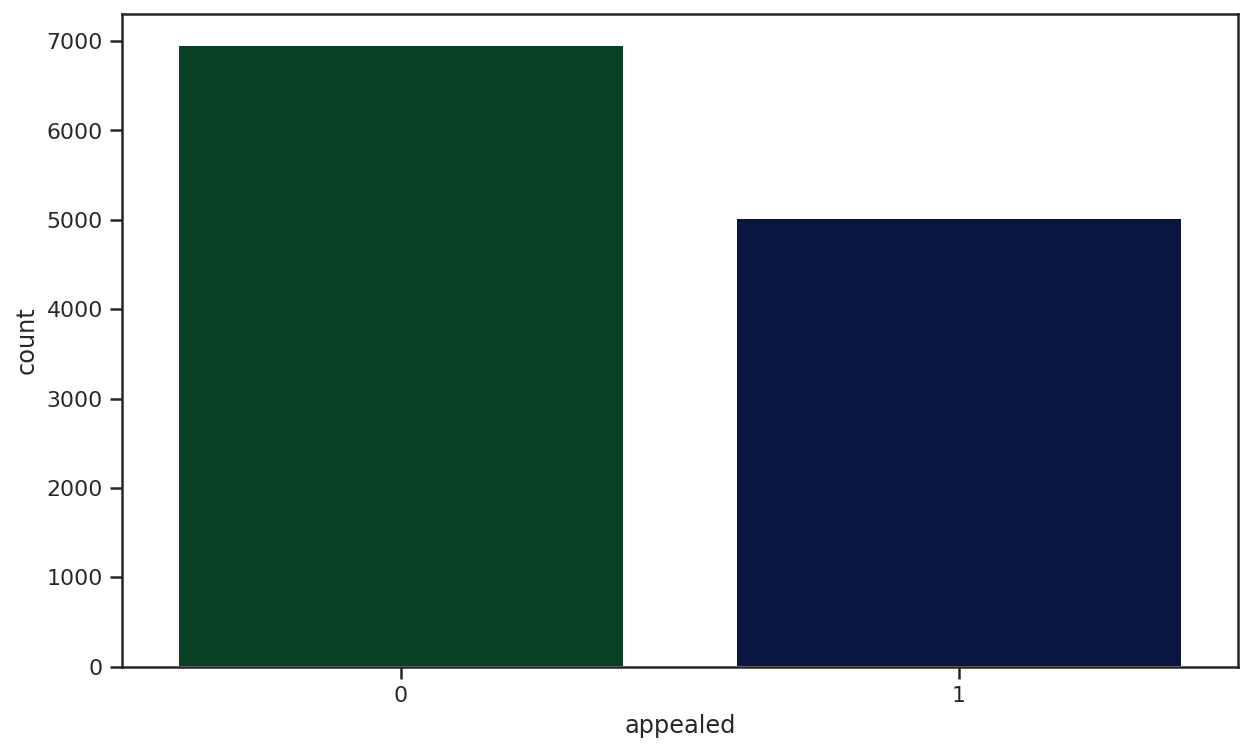

In [423]:
#sns.displot(y)
sns.countplot('appealed',  data=df)
plt.show()

As can be seen above, a significant share of people in our dataset have appealed. Let's see what type of people appealed.

In [424]:
df.groupby(df["appealed"]).mean()

av1          value  ...  log_beds    log_av1
appealed                               ...                     
0         21973.908673  254827.225370  ...  1.146593   9.861064
1         30162.515351  308904.904306  ...  1.187761  10.167255

[2 rows x 27 columns]

- Seemingly, white homeowners, tend to appeal more often. As well as, homeowners with higher values tend to appeal more often and present higher appeal values.
- People who appeal are more likely to be college educated and homeoners as well. 

In [425]:
df_new.shape

(3397, 34)

In [426]:
df_new.columns

Index(['pin14', 'tri', 'pstreet', 'pcity', 'tcity', 'condo', 'av1', 'value',
       'taxes', 'homeowner', 'white', 'black', 'hispanic', 'asian', 'medhinc',
       'poverty', 'college', 'squarefoot', 'beds', 'walkscore', 'walkfac',
       'elem_score', 'high_school_score', 'avg_school_score', 'appeal',
       'appealed', 'log_av1', 'log_taxes', 'ratio_av1_value', 'log_appeal',
       'walkfac_Car-Dependent', 'walkfac_Somewhat Walkable',
       'walkfac_Very Walkable', 'walkfac_Walker's Paradise'],
      dtype='object')

In [427]:
df_new.head()

pin14      tri  ... walkfac_Very Walkable walkfac_Walker's Paradise
2  1.408420e+13  Chicago  ...                     1                         0
3  1.419130e+13  Chicago  ...                     1                         0
7  1.433410e+13  Chicago  ...                     0                         1
8  1.405320e+13  Chicago  ...                     0                         1
9  1.313300e+13  Chicago  ...                     1                         0

[5 rows x 34 columns]

In [428]:
df=df.drop(columns=["tri","pstreet","pcity","tcity","walkfac"])

**Adding ratio columns to see if any of the relationships influence appeals**

In [429]:
df['av1.div.value'] = df['av1']/df['value']
df['taxes.div.value'] = df['taxes']/df['value']
df['taxes.div.medhinc'] = df['taxes']/df['medhinc']
df['taxes.div.squarefoot'] = df['taxes']/df['squarefoot']
df['value.div.squarefoot'] = df['value']/df['squarefoot']
df['college.div.avg_school_score'] = df['college']/df['avg_school_score']
df['white.div.black'] = df['white']/df['black']
df['white.div.hispanic'] = df['white']/df['hispanic']
df['white.div.asian'] = df['white']/df['asian']

In [430]:
df.shape

(11969, 37)

**Selecting numerical columns**

In [431]:
data_columns = list(df.columns)
numerical_df = (df.drop(data_columns, axis=1)
         .join(df[data_columns].apply(pd.to_numeric, errors='coerce')))

In [432]:
numerical_df = numerical_df[numerical_df[data_columns].notnull().all(axis=1)]

**We split the test set and training set with a ratio of 0.33 and make our 'X' and 'y' variables**

In [433]:
X = numerical_df.drop('appealed', axis=1)
y = numerical_df['appealed']

In [434]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

**Logit Model**

In [435]:
df.columns

Index(['av1', 'value', 'taxes', 'homeowner', 'white', 'black', 'hispanic',
       'asian', 'medhinc', 'poverty', 'college', 'squarefoot', 'beds',
       'walkscore', 'elem_score', 'high_school_score', 'avg_school_score',
       'appeal', 'appealed', 'pin_area', 'pin_sub_area', 'pin_block',
       'log_taxes', 'log_squarefoot', 'log_medhinc', 'log_value', 'log_beds',
       'log_av1', 'av1.div.value', 'taxes.div.value', 'taxes.div.medhinc',
       'taxes.div.squarefoot', 'value.div.squarefoot',
       'college.div.avg_school_score', 'white.div.black', 'white.div.hispanic',
       'white.div.asian'],
      dtype='object')

In [436]:
appendix_df=df

### After testing the model with various combination of variables, we found that the following combination yields the best results

In [437]:
X_train_2 = X_train[['av1','value','taxes','log_squarefoot','medhinc','beds','homeowner','white',
                     'black','hispanic','asian','college',
                     'walkscore','appeal',
                     'taxes.div.value']]
logit_model_v2 =sm.Logit(y_train,X_train_2)
result_v2 =logit_model_v2.fit()
print(result_v2.summary())

         Current function value: 0.403615
         Iterations: 35
                           Logit Regression Results                           
Dep. Variable:               appealed   No. Observations:                 8019
Model:                          Logit   Df Residuals:                     8004
Method:                           MLE   Df Model:                           14
Date:                Sat, 02 Jan 2021   Pseudo R-squ.:                  0.4063
Time:                        15:39:35   Log-Likelihood:                -3236.6
converged:                      False   LL-Null:                       -5451.4
Covariance Type:            nonrobust   LLR p-value:                     0.000
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
av1              4.586e-05   5.75e-06      7.980      0.000    3.46e-05    5.71e-05
value           -9.869e-08   5.08e-07     -0.194  

### Important factors are assessed value square footage, the median income of the property, and race amongst others (as can be seen where p value is clost to zero

In [438]:
X_train_2.describe()

av1          value  ...        appeal  taxes.div.value
count   8019.000000    8019.000000  ...   8019.000000      8019.000000
mean   25335.371368  277114.352039  ...   1131.363013         0.018402
std    14055.030860  155043.829634  ...   3735.270114         0.010834
min      878.000000   17500.000000  ...      0.000000         0.000002
25%    14865.500000  160000.000000  ...      0.000000         0.011570
50%    22060.000000  240000.000000  ...      0.000000         0.015677
75%    32473.500000  355000.000000  ...      0.000000         0.022576
max    72567.000000  804019.000000  ...  74911.000000         0.139548

[8 rows x 15 columns]

### Using sklearn we make a logistic regression model to evaluate precision-recall metrics and analyze false-positives and false-negatives

#### We need some code to remove any NaN / infinity values

In [439]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

In [440]:
y_train = y_train.to_frame()

In [441]:
clean_dataset(X_train_2)
clean_dataset(y_train)
clean_dataset(X_test)

av1     value  ...  white.div.hispanic  white.div.asian
12464  14292.0  154900.0  ...            3.370629         4.796020
2010   30395.0  225000.0  ...            1.462198         2.734694
17213  33910.0  400000.0  ...            1.074134         2.340802
4830   19216.0  220000.0  ...            0.875874         1.237037
448    25303.0  360000.0  ...            2.040750         4.050064
...        ...       ...  ...                 ...              ...
4500   30929.0  160000.0  ...            3.081772         1.369936
17453   9803.0  130000.0  ...            2.721804         6.277457
17248  20552.0  132500.0  ...            1.756816         3.131195
16032  29376.0  350000.0  ...            0.444280         0.805903
62     34551.0  363000.0  ...            5.081657         6.196248

[3949 rows x 36 columns]

In [442]:
logmodel = LogisticRegression()
logmodel.fit(X_train_2, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

### Cleaning data array for nan and infinite values 

In [443]:
# df =df[~df.isin([np.nan, np.inf, -np.inf]).any(1)]

X_test_1 = X_test.copy()

X_test_1 = X_test_1[~X_test_1.isin([np.nan, np.inf, -np.inf]).any(1)]

X_test_1 = X_test_1[['av1','value','taxes','log_squarefoot','medhinc','beds','homeowner','white',
                     'black','hispanic','asian','college',
                     'walkscore','appeal',
                     'taxes.div.value']]


### Setting correct dataframe dimensions to run model

In [444]:
y_test_1 = y_test.copy()

y_test_1 = y_test_1[:-1]

In [445]:
predictions = logmodel.predict(X_test_1)
print(classification_report(y_test_1, predictions))
print(confusion_matrix(y_test_1, predictions))
print(accuracy_score(y_test_1, predictions))

              precision    recall  f1-score   support

           0       0.73      0.93      0.82      2290
           1       0.84      0.51      0.64      1659

    accuracy                           0.76      3949
   macro avg       0.78      0.72      0.73      3949
weighted avg       0.78      0.76      0.74      3949

[[2132  158]
 [ 806  853]]
0.7558875664725246


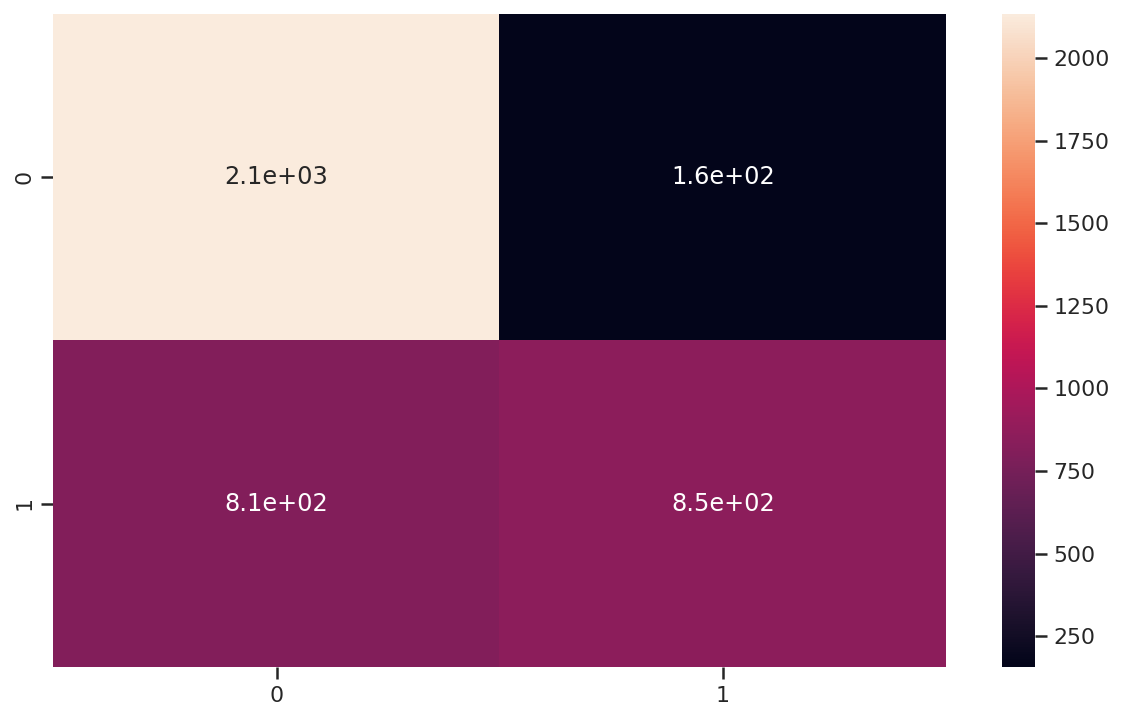

In [446]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test_1,predictions)),annot=True)
plt.show()

### The model is about 75% accurate and there are still a material number of false positives/negatives.








### Applying Standard Scaler to optimize results

In [447]:
s_sc = StandardScaler()
X_train_scaled = s_sc.fit_transform(X_train_2)
#X_test_scaled = sc.transform(X_test_1)

In [448]:
logmodel_scale = LogisticRegression()
logmodel_scale.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [449]:
X_test_scaled = s_sc.transform(X_test_1)

In [450]:
predictions_scaled = logmodel_scale.predict(X_test_scaled)
print(classification_report(y_test_1, predictions_scaled))
print(confusion_matrix(y_test_1, predictions_scaled))
print(accuracy_score(y_test_1, predictions_scaled))

              precision    recall  f1-score   support

           0       0.73      0.92      0.82      2290
           1       0.83      0.53      0.65      1659

    accuracy                           0.76      3949
   macro avg       0.78      0.73      0.73      3949
weighted avg       0.77      0.76      0.75      3949

[[2116  174]
 [ 780  879]]
0.758419853127374


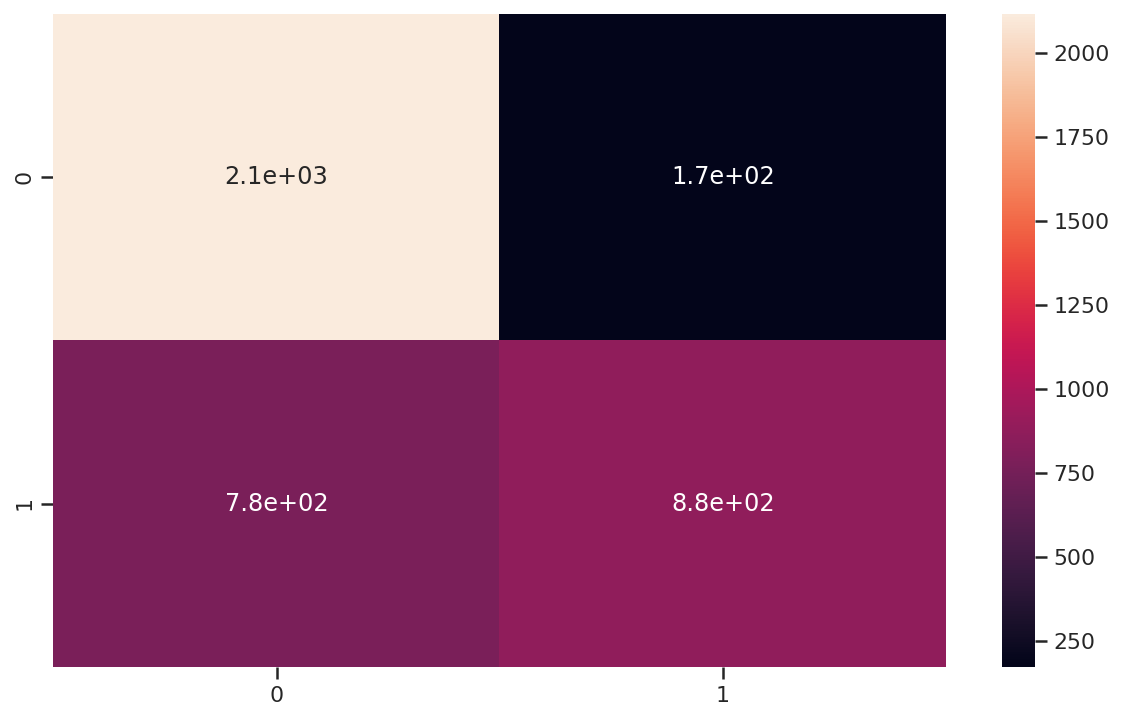

In [451]:
sns.heatmap(pd.DataFrame(confusion_matrix(y_test_1,predictions_scaled)),annot=True)
plt.show()

### The standard scaler does not increase the accuracy of the model by any significant margin

# Regression model to answer the second question - what is the monetary reduction someone would get once the appeal

In [452]:
df=pd.read_csv("https://raw.githubusercontent.com/openstrategist/Advanced-Statistical-Analysis-uChicago/main/project2.csv")

### We start with the original dataset again

In [453]:
df.shape

(19036, 26)

In [454]:
# Find duplicate rows
duplicate_rows = df[df.duplicated()]
print('We have', len(duplicate_rows), 'observations in the dataset. Duplicates will be removed in the next step.')

We have 132 observations in the dataset. Duplicates will be removed in the next step.


In [455]:
df.drop_duplicates(subset=None, keep='first', inplace=True, ignore_index=False)
df.shape

(18904, 26)

In [456]:
# Variable pdir : for now, let's replace NAs by 'Unknown'.
df["pdir"].fillna('Unknown', inplace = True)

In [457]:
df["appeal"].head()

0        0.0
1        0.0
2     4199.0
3    39109.0
4        0.0
Name: appeal, dtype: float64

### We create a new column 'appealed' to capture those who appealed

In [458]:
# Create a list of our conditions
conditions = [
    (df["appeal"] >= 0),
    (df["appeal"].isna())
    ]

# Create a list of the values we want to assign for each condition
values = [1, 0]

# Create a new column and use np.select to assign values to it using our lists as arguments
df["appealed"] = np.select(conditions, values)
df["appealed"] = df["appealed"].astype("category")

# Now, replace NA values with O to avoid these rows to be deleted
df["appeal"].fillna(0, inplace = True)

# Number of row before removing outliers
df.shape

(18904, 27)

In [459]:
# Removing missing values, now that we have applied a specific treatment to the appeal variable, we can remove missing values
df.dropna(inplace=True)

# No more missing values
df.isna().sum()

pin14                0
tri                  0
pdir                 0
pstreet              0
pcity                0
tcity                0
condo                0
av1                  0
value                0
taxes                0
homeowner            0
white                0
black                0
hispanic             0
asian                0
medhinc              0
poverty              0
college              0
squarefoot           0
beds                 0
walkscore            0
walkfac              0
elem_score           0
high_school_score    0
avg_school_score     0
appeal               0
appealed             0
dtype: int64

### Now we only consider cases where there has been an appeal to build a model for monetary reduction

In [460]:
# Filtering on appealed = yes
df = df[(df["appealed"] == 1)]

df.shape

(6341, 27)

In [461]:
# So, if we have taxes = 0, there is no reasons to appeal
count_zero = len(df[df["taxes"]==0])
count_total = len(df)
pct_zero = count_zero/count_total

print("Number of rows with taxes = 0 is", count_zero)
print("Percentage of rows with taxes = 0 is", round(pct_zero*100,2))

df = df[(df["taxes"] > 0)]

Number of rows with taxes = 0 is 26
Percentage of rows with taxes = 0 is 0.41


In [462]:
# Let's count the number of property owners who lost the appeal process.  
# We could create a model to understand why they lost their appeal but let's try to focus on owners who win their appeal to understand the amount reduction
count_zero = len(df[df["appeal"]==0])
count_total = len(df)
pct_zero = count_zero/count_total

print("Number of rows with appeal = 0 is", count_zero)
print("Percentage of rows with appeal = 0 is", round(pct_zero*100,2))

df = df[(df["appeal"] > 0)]

Number of rows with appeal = 0 is 2617
Percentage of rows with appeal = 0 is 41.44


In [463]:
# Number of owners who win their appeal and get some reduction
df.shape

(3698, 27)

In [464]:
count_negative = len(df[df["av1"] < 0])
count_total = len(df)
pct_negative = count_negative/count_total

print("Number of rows with negative av1 is", count_negative)
print("Percentage of rows with negative av1 is", round(pct_negative*100,2))

Number of rows with negative av1 is 160
Percentage of rows with negative av1 is 4.33


In [465]:
# Removing negative values for av1
df = df[(df["av1"] >= 0)]

In [466]:
df["log_av1"] = np.log(df["av1"])

IQR for log of <av1> is : 0.9336369276098111
Lower cut-offs is : 8.59288428612047
Upper cut-offs is : 12.327431996559714
New skew is : 0.07712821305558576


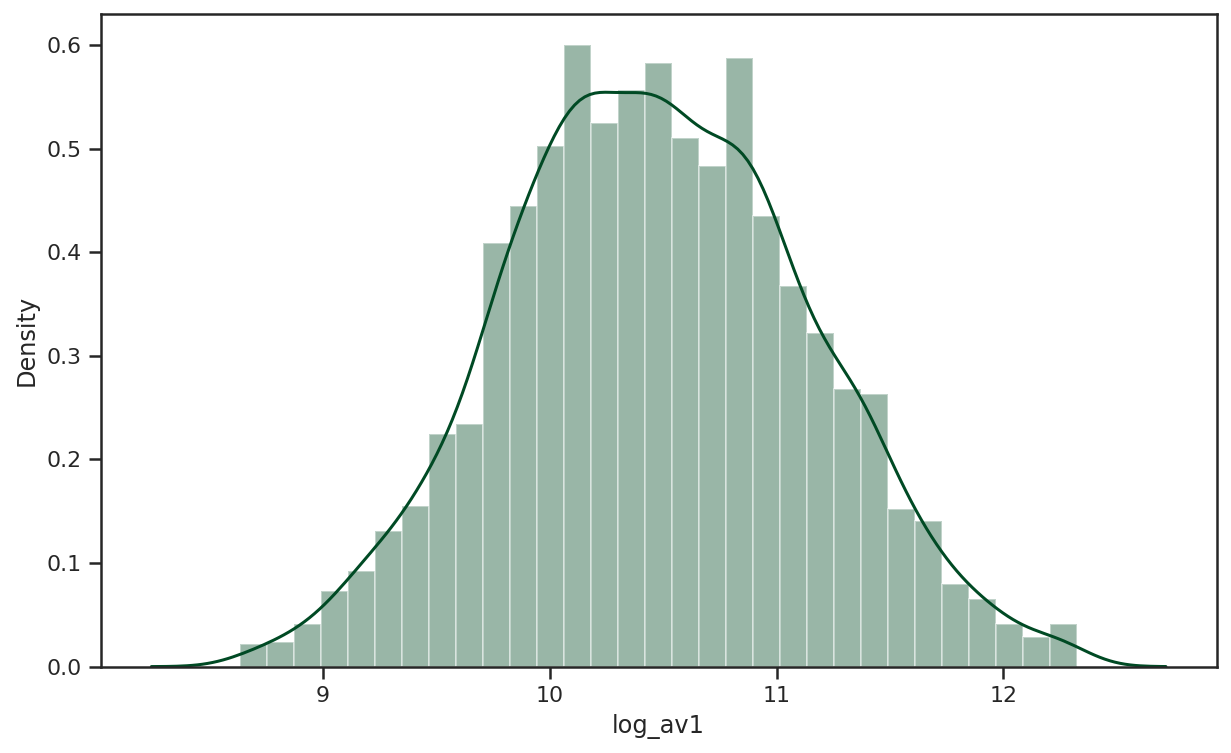

In [467]:
# Calculate IQR
Log_av1_IQR = iqr(df["log_av1"])
print('IQR for log of <av1> is : {}'.format(Log_av1_IQR))

# Calculate upper and lower cut-offs
Q1 = np.quantile(df["log_av1"], .25)
lower_cut_off = Q1 - (1.5 * Log_av1_IQR)
print('Lower cut-offs is : {}'.format(lower_cut_off))

Q3 = np.quantile(df["log_av1"], .75)
upper_cut_off = Q3 + (1.5 * Log_av1_IQR)
print('Upper cut-offs is : {}'.format(upper_cut_off))

# Remove data that falls below or above the cut off
df = df[(df["log_av1"] > lower_cut_off) & (df["log_av1"] < upper_cut_off)]

# Calculate the skew
new_skew = df['log_av1'].skew() 
print('New skew is : {}'.format(new_skew))

# Visualizing the variable
f, axes = plt.subplots(figsize=(10,6))
sns.distplot(df['log_av1'])

In [468]:
df.shape

(3475, 28)

In [469]:
df["log_taxes"] = np.log(df["taxes"])

IQR for log of <taxes> is : 0.8661552027490131
Lower cut-offs is : 6.900273895769949
Upper cut-offs is : 10.364894706766002
New skew is : -0.05227236896617419


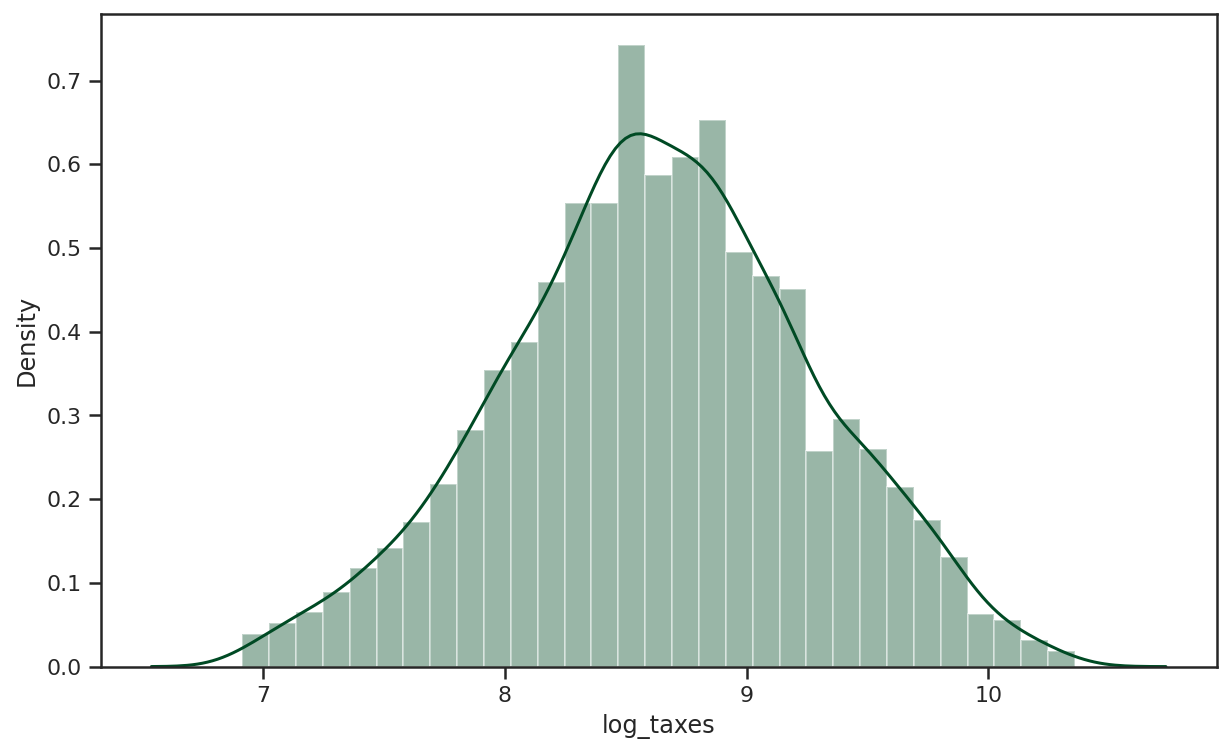

In [470]:
# Calculate IQR
Log_taxes_IQR = iqr(df["log_taxes"])
print('IQR for log of <taxes> is : {}'.format(Log_taxes_IQR))

# Calculate upper and lower cut-offs
Q1 = np.quantile(df["log_taxes"], .25)
lower_cut_off = Q1 - (1.5 * Log_taxes_IQR)
print('Lower cut-offs is : {}'.format(lower_cut_off))

Q3 = np.quantile(df["log_taxes"], .75)
upper_cut_off = Q3 + (1.5 * Log_taxes_IQR)
print('Upper cut-offs is : {}'.format(upper_cut_off))

# Remove data that falls below or above the cut off
df = df[(df["log_taxes"] > lower_cut_off) & (df["log_taxes"] < upper_cut_off)]

# Calculate the skew
new_skew = df['log_taxes'].skew() 
print('New skew is : {}'.format(new_skew))

# Visualizing the variable
f, axes = plt.subplots(figsize=(10,6))
sns.distplot(df['log_taxes'])

### We create a ratio of av1 and value

In [471]:
df["ratio_av1_value"] = df["av1"]/df["value"]

In [472]:
df.shape

(3430, 30)

In [473]:
df["log_appeal"] = np.log(df["appeal"])

IQR for log of <appeal> is : 1.5025000826197736
Lower cut-offs is : 5.190644681665916
Upper cut-offs is : 11.20064501214501
New skew is : 0.33855279047980996


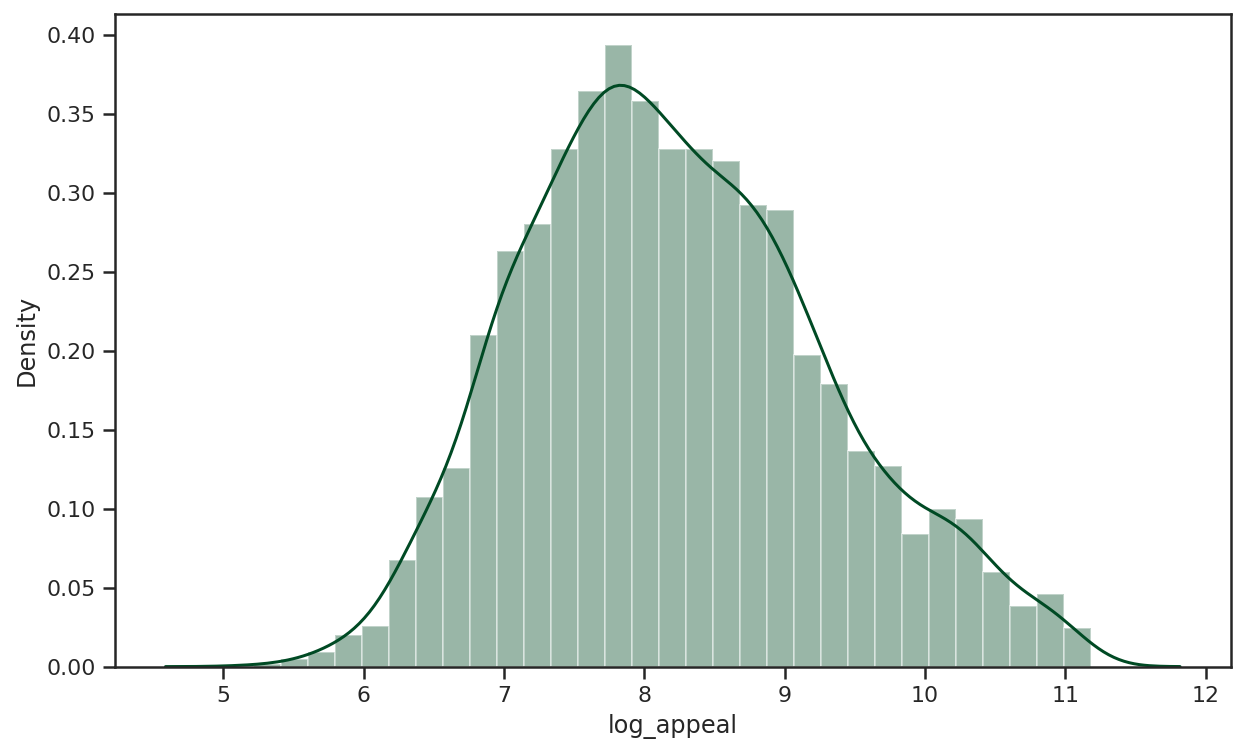

In [474]:
# Calculate IQR
Log_appeal_IQR = iqr(df["log_appeal"])
print('IQR for log of <appeal> is : {}'.format(Log_appeal_IQR))

# Calculate upper and lower cut-offs
Q1 = np.quantile(df["log_appeal"], .25)
lower_cut_off = Q1 - (1.5 * Log_appeal_IQR)
print('Lower cut-offs is : {}'.format(lower_cut_off))

Q3 = np.quantile(df["log_appeal"], .75)
upper_cut_off = Q3 + (1.5 * Log_appeal_IQR)
print('Upper cut-offs is : {}'.format(upper_cut_off))

# Remove data that falls below or above the cut off
df = df[(df["log_appeal"] > lower_cut_off) & (df["log_appeal"] < upper_cut_off)]

# Calculate the skew
new_skew = df['log_appeal'].skew() 
print('New skew is : {}'.format(new_skew))

# Visualizing the variable
f, axes = plt.subplots(figsize=(10,6))
sns.distplot(df['log_appeal'])

### Final model: We iterated and tried various combinations and mutations of models to develop a simple OLS.

In [475]:
import statsmodels.formula.api as sm
formula4= "log_appeal ~  ratio_av1_value + log_av1 + log_taxes - 1"
model4 = sm.ols(formula=formula4, data=df)
result4 = model4.fit()
result_summary4 = result4.summary()
print(result_summary4)

                                 OLS Regression Results                                
Dep. Variable:             log_appeal   R-squared (uncentered):                   0.990
Model:                            OLS   Adj. R-squared (uncentered):              0.990
Method:                 Least Squares   F-statistic:                          1.074e+05
Date:                Sat, 02 Jan 2021   Prob (F-statistic):                        0.00
Time:                        15:39:38   Log-Likelihood:                         -4255.5
No. Observations:                3397   AIC:                                      8517.
Df Residuals:                    3394   BIC:                                      8535.
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

### The above OLS has 99% adjusted r-squared, a low condition number and low skewness. As such, we conclude that we have a good working model for reductions in tax values from appeals.
### Just three variables (log av1, log taxes, and ratio of av1 to value) are sufficient to develop a good model.

# Conclusion

After extensive analysis of the given data we were able to build models that predicted the likelihood of appeal and models that predicted the magnitude of the monetary reduction that would be won on appeal. We were able to formulate these models by first exploring the dataset. We cleaned the data for outliers and took steps to remove skew from each of the factors. In addition, we transformed the data and created new factors that provided us insights into our models. 

For determining whether a person will appeal or not, the major factors that proved significant in our model were the value and assessed value of the property, the race of the people living at the property, and level of the income of the household. In general, properties that have higher assessed values are unsurprisingly more likely to appeal in order to get their taxes lowered. We were able to construct a model that achieved 75% accuracy on the test data using these factors.


We also created models for the amount of monetary reduction won on appeal. Our modeling of this scenario was quite successful in that we were able to build a highly accurate model with relatively low dimensionality. The major factors in our model were the the property's assesed value, the ratio of assessed value to actualy property value, and taxes. This further shows that properties that have high values and are paying a lot of taxes are the ones that are most likely to appeal and that the taxes and value of the properties are a huge barometer for the amount of monetary reduction to expect. 


Given more time we would probably seek to augment our findings with a text based analysis of the appeals. If we could perform a text analysis of a large swath of appeals we could determine if certain appeals that have common language in them are more successful than other appeals and further add to the models that we have built.

An additional area of investigation could be - corrections to negative race-related consequences with our model. We should further investigate and ensure that the model doesn't punish those people who are low income or of non-white race.

#APPENDIX